In [9]:
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Lambda,Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.models import Sequential  #用來啟動 NN
from tensorflow.keras.layers import Conv2D  # Convolution Operation
from tensorflow.keras.layers import MaxPooling2D # Pooling
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense # Fully Connected Networks
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate, AveragePooling2D, UpSampling2D, add, Multiply, GlobalAveragePooling2D
import tensorflow.keras as keras  
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import os
import random
import re
import time
from random import shuffle
from matplotlib import pyplot as plt
from scipy.stats import norm
import statistics

In [10]:
def data_collect(Path):
    files=os.listdir(Path)
    random.shuffle(files)
    Train_Lstm=[]
    Label=[]
    Train=[]
    Train
    count=1
    Train_Pdf=[]
    Time_lists = []
    for file in files:
        Time_lists.append(file)
        start=time.time()
        Break=0
        global Train_pdf, Label_Pdf
        Train_lstm=[]
        file_data=os.listdir(Path+file)
        
        ##CNN_PDF
        #CSFV2
        df_csfv2 = pd.read_csv(Path+file+'/'+file_data[0],header=None)
        df_era5 = pd.read_csv(Path+file+'/'+file_data[1],header=None)
        for column in df_csfv2.columns[2:7]:
            if column == df_csfv2.columns[2]:
                Train_pdf=np.array(np.array(df_csfv2[column]).reshape(61,101,1))
            else:
                Train_pdf=np.append(Train_pdf,np.array(df_csfv2[column]).reshape(61,101,1),axis=2)
                
        #ERAF
        for column in df_era5.columns[2:12]:
            Train_pdf=np.append(Train_pdf,np.array(df_era5[column]).reshape(61,101,1),axis=2)

        ##LSTM
        #ERA5
        df_1 = pd.read_csv(Path+file+'/'+file_data[3])
        for column in df_1.columns[1:91]:
            if' NaN' in list(df_1[column])[:]:
                Break=1
                break
            Train_lstm.append(list(df_1[column]))
            
        #CSFV2
        df_2 = pd.read_csv(Path+file+'/'+file_data[2])
        for column in df_2.columns[1:181]:
            if' NaN' in list(df_2[column])[:]:
                Break=1
                break
            Train_lstm.append(list(df_2[column]))
        if Break==1:
            continue

        ##LABEL_PDF 
        for column in df_era5.columns[7:17]:
            if column == df_era5.columns[7]:
                Label_Pdf=np.array(np.array(df_era5[column]).reshape(61,101,1))
                #print(Label_Pdf)
            else:
                Label_Pdf=np.append(Label_Pdf,np.array(df_era5[column]).reshape(61,101,1),axis=2)

        Train_Pdf.append(Train_pdf)
        Train_Lstm.append(Train_lstm)
        Label.append(Label_Pdf)
        end=time.time()
        Time=(end-start)*(len(files)-count)
        print('%d / %d , Time : %d : %d : %d'%(count,len(files),int(Time/3600),int(Time%3600/60),Time%3600%60),end='\r')
        count=count+1
    Train.append(Train_Pdf)
    Train.append(Train_Lstm)
    Label=np.array(Label)
    return Train, Label, Time_lists

In [22]:
#資料位置
Path='Data/Test/'

#載入資料
Valid,Valid_Label,Time_lists=data_collect(Path)

#模型位置
model_path = 'Model/LSMT_Restnet_new_data_my_loss_only_CNN_180days.h5'

#預測CSV儲存位置
Path_perdict_csv = 'Predict_csv/CNN/'

In [18]:
Valid_Pdf=Valid[0]
Valid_Lstm=Valid[1]
Valid_Pdf=np.array(Valid_Pdf)
Valid_Lstm=np.array(Valid_Lstm)
print('Valid_Lstm:',Valid_Lstm.shape)
print('Train_Pdf:',Valid_Pdf.shape)

Valid_Lstm: (92, 270, 10)
Train_Pdf: (92, 61, 101, 15)


In [19]:
def mcustom_loss(y_true, y_pred):

    trueAvg = (y_true[:,:,:,0][:,:,:,np.newaxis]-Mean[0])/(Max[0]-Min[0])
    trueStd = (y_true[:,:,:,1][:,:,:,np.newaxis]-Mean[1])/(Max[1]-Min[1])
    trueMax = (y_true[:,:,:,2][:,:,:,np.newaxis]-Mean[2])/(Max[2]-Min[2])
    trueMin = (y_true[:,:,:,3][:,:,:,np.newaxis]-Mean[3])/(Max[3]-Min[3])
    trueSkw = (y_true[:,:,:,4][:,:,:,np.newaxis]-Mean[4])/(Max[4]-Min[4])

    predAvg = (y_pred[:,:,:,0][:,:,:,np.newaxis]-Mean[0])/(Max[0]-Min[0])
    predStd = (y_pred[:,:,:,1][:,:,:,np.newaxis]-Mean[1])/(Max[1]-Min[1])
    predMax = (y_pred[:,:,:,2][:,:,:,np.newaxis]-Mean[2])/(Max[2]-Min[2])
    predMin = (y_pred[:,:,:,3][:,:,:,np.newaxis]-Mean[3])/(Max[3]-Min[3])
    predSkw = (y_pred[:,:,:,4][:,:,:,np.newaxis]-Mean[4])/(Max[4]-Min[4])
    
    trueAvg_180 = (y_true[:,:,:,5][:,:,:,np.newaxis]-Mean[5])/(Max[5]-Min[5])
    trueStd_180 = (y_true[:,:,:,6][:,:,:,np.newaxis]-Mean[6])/(Max[6]-Min[6])
    trueMax_180 = (y_true[:,:,:,7][:,:,:,np.newaxis]-Mean[7])/(Max[7]-Min[7])
    trueMin_180 = (y_true[:,:,:,8][:,:,:,np.newaxis]-Mean[8])/(Max[8]-Min[8])
    trueSkw_180 = (y_true[:,:,:,9][:,:,:,np.newaxis]-Mean[9])/(Max[9]-Min[9])

    predAvg_180 = (y_pred[:,:,:,5][:,:,:,np.newaxis]-Mean[5])/(Max[5]-Min[5])
    predStd_180 = (y_pred[:,:,:,6][:,:,:,np.newaxis]-Mean[6])/(Max[6]-Min[6])
    predMax_180 = (y_pred[:,:,:,7][:,:,:,np.newaxis]-Mean[7])/(Max[7]-Min[7])
    predMin_180 = (y_pred[:,:,:,8][:,:,:,np.newaxis]-Mean[8])/(Max[8]-Min[8])
    predSkw_180 = (y_pred[:,:,:,9][:,:,:,np.newaxis]-Mean[9])/(Max[9]-Min[9])

    loss = ((K.square(predMin - trueMin) + K.square(predMax - trueMax) + K.square(predSkw - trueSkw) +
            K.square(predAvg - trueAvg) + K.square(predStd - trueStd))+
            (K.square(predMin_180 - trueMin_180) + K.square(predMax_180 - trueMax_180) + K.square(predSkw_180 - trueSkw_180) +
            K.square(predAvg_180 - trueAvg_180) + K.square(predStd_180 - trueStd_180)))/10
    loss = K.mean(loss, axis=-1)

    return loss

In [20]:
Max=[307.9367, 17.7063, 313.7215, 304.4253, 3.8382,310.1568,18.0352,314.7128,306.1226,2.7172]
Min=[232.6118, 0.1771, 244.0102, 204.4635, -4.7362,234.9248,0.1928,248.2585,220.1559,-4.1973]
Mean=[287.3242734287198,
     3.349621542723795,
     293.65658980295865,
     279.6666574399456,
     -0.25665387472126,
     288.3584796428863,
     3.2974777666300223,
     294.7044402373835,
     281.08416123969715,
     -0.15500007492913936]

In [23]:
from tensorflow import keras
model = load_model(model_path,custom_objects={'mcustom_loss': mcustom_loss})

In [24]:
batchSize=1
y_predict=model.predict(Valid_Pdf,batchSize)

In [27]:
for day in range(len(y_predict)):
    CSV = []
    for i in range(61):
        for j in range(101):
            CSV_PER = []
            CSV_PER.append(i+1)
            CSV_PER.append(j+1)
            for k in y_predict[day][i][j]:
                CSV_PER.append(k)
            CSV.append(CSV_PER)
    df= pd.DataFrame(CSV,columns=['X','Y','Mean_90','STD_90','Maximum_90','Minimum_90','Skewness_90','Mean_180','STD_180','Maximum_180','Minimum_180','Skewness_180'])
    #df.to_csv(Path_perdict_csv+Time_lists[day]+'.csv',index=False)

In [29]:
def PDF_point(i, j, data, start, end, Pic):
    PDF=[0,0,0,0,0,0,0,0,0,0]
    PDF_csfv2=[0,0,0,0,0,0,0,0,0,0]
    LABEL = ['X_90','Y_90','Mean_90','STD_90','Maximum_90','Minimum_90','Skewness_90','X_180','Y_180','Mean_180','STD_180','Maximum_180','Minimum_180','Skewness_180']
    Era5=[]
    Csfv2=[]
    Predict=[]
    for pdf in range(start, end):                
        count=Valid_Label[Pic][i][j][pdf]
        count_data=data[i][j][pdf]
        count_csfv2=Valid_Pdf[Pic][i][j][5+pdf]
        Era5.append(round(count,2))
        Csfv2.append(round(count_csfv2,2))
        Predict.append(round(count_data,2))
    print("Point:",i,j)
    print(Pic+1,pdf,'ERA5:',round(count,2),"CSFV2:",round(count_csfv2,2),'Predict:',round(count_data,2))
    Era5_pdf = np.arange(Era5[3],Era5[2],0.1)
    Csfv2_pdf = np.arange(Csfv2[3],Csfv2[2],0.1)
    Predict_pdf = np.arange(Predict[3],Predict[2],0.1)
    plt.plot(Era5_pdf, norm.pdf(Era5_pdf, Era5[0], Era5[1]),label='ERA5' )
    plt.plot(Csfv2_pdf, norm.pdf(Csfv2_pdf, Csfv2[0], Csfv2[1]),label='CSFV2' )
    plt.plot(Predict_pdf, norm.pdf(Predict_pdf, Predict[0], Predict[1]),label='Predict' )
    plt.legend()
    plt.show()    

In [ ]:
def PDF_average(data, start, end, Pic):
    PDF=[0,0,0,0,0,0,0,0,0,0]
    PDF_csfv2=[0,0,0,0,0,0,0,0,0,0]
    LABEL = ['X_90','Y_90','Mean_90','STD_90','Maximum_90','Minimum_90','Skewness_90','X_180','Y_180','Mean_180','STD_180','Maximum_180','Minimum_180','Skewness_180']
    Era5=[]
    Csfv2=[]
    Predict=[]
    for pdf in range(start,end):
        count=0
        count_data=0
        count_csfv2=0
        for i in range(len(data)):
            for j in range(len(data[0])):
                count=count+Valid_Label[Pic][i][j][pdf]
                count_data=count_data+data[i][j][pdf]
                count_csfv2=count_csfv2+Valid_Pdf[Pic][i][j][5+pdf]
        print(Pic+1,LABEL[pdf],'ERA5:',round(count/(61*101),2),"CSFV2:",round(count_csfv2/(61*101),2),'Predict:',round(count_data/(61*101),2))
        
        Era5.append(round(count/(61*101),2))
        Csfv2.append(round(count_csfv2/(61*101),2))
        Predict.append(round(count_data/(61*101),2))
    Era5_pdf = np.arange(Era5[3],Era5[2],0.1)
    Csfv2_pdf = np.arange(Csfv2[3],Csfv2[2],0.1)
    Predict_pdf = np.arange(Predict[3],Predict[2],0.1)
    plt.plot(Era5_pdf, norm.pdf(Era5_pdf, Era5[0], Era5[1]),label='ERA5' )
    plt.plot(Csfv2_pdf, norm.pdf(Csfv2_pdf, Csfv2[0], Csfv2[1]),label='CSFV2' )
    plt.plot(Predict_pdf, norm.pdf(Predict_pdf, Predict[0], Predict[1]),label='Predict' )
    plt.legend()
    plt.show()

前90天
Point: 0 0
1 4 ERA5: -0.19 CSFV2: -0.09 Predict: 0.3


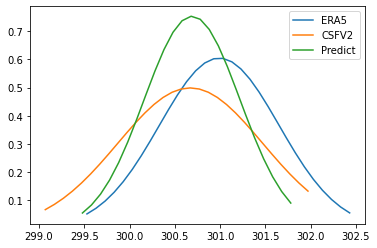

後90天
Point: 0 0
1 9 ERA5: -0.87 CSFV2: 0.48 Predict: -1.22


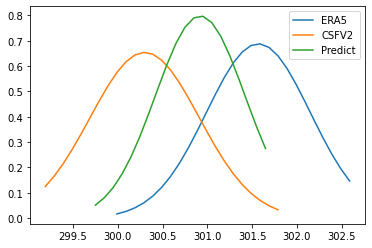

前90天
Point: 0 1
1 4 ERA5: -0.41 CSFV2: -0.1 Predict: 0.17


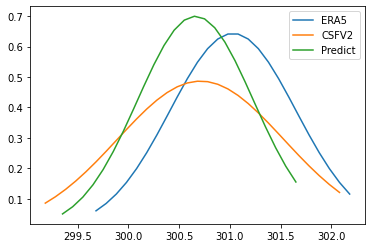

後90天
Point: 0 1
1 9 ERA5: -0.63 CSFV2: 0.44 Predict: -0.81


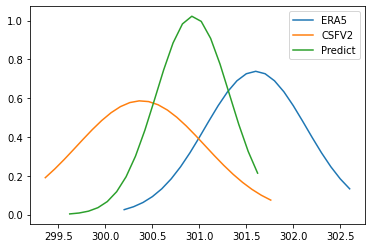

前90天
Point: 0 2
1 4 ERA5: -0.71 CSFV2: -0.03 Predict: 0.43


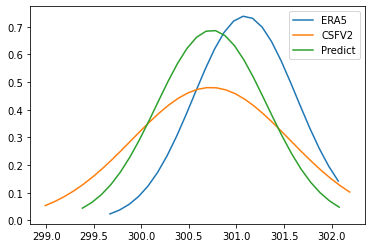

後90天
Point: 0 2
1 9 ERA5: -0.71 CSFV2: 0.05 Predict: -1.12


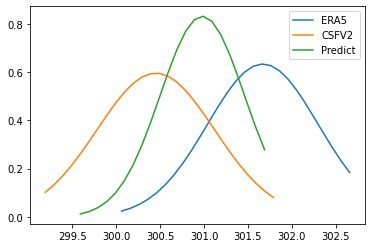

前90天
Point: 0 3
1 4 ERA5: -0.67 CSFV2: -0.07 Predict: 0.31


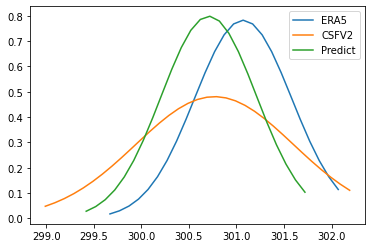

後90天
Point: 0 3
1 9 ERA5: -0.72 CSFV2: -0.06 Predict: -0.94


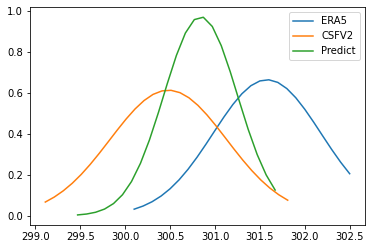

前90天
Point: 0 4
1 4 ERA5: -0.39 CSFV2: -0.1 Predict: 0.4


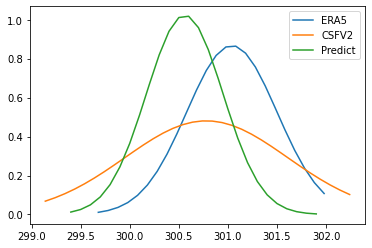

後90天
Point: 0 4
1 9 ERA5: -1.05 CSFV2: -0.19 Predict: -1.03


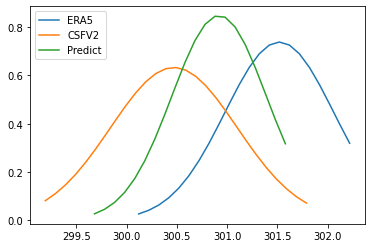

前90天
Point: 0 5
1 4 ERA5: -0.35 CSFV2: -0.15 Predict: 0.27


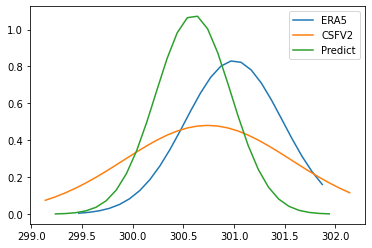

後90天
Point: 0 5
1 9 ERA5: -0.96 CSFV2: -0.03 Predict: -0.62


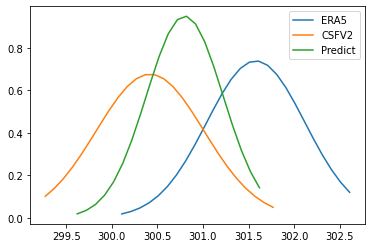

前90天
Point: 0 6
1 4 ERA5: -0.57 CSFV2: -0.23 Predict: 0.07


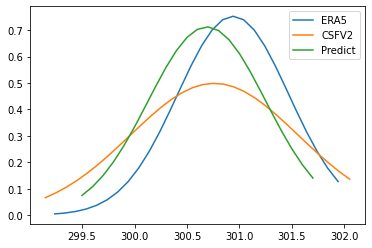

後90天
Point: 0 6
1 9 ERA5: -0.39 CSFV2: -0.09 Predict: -0.71


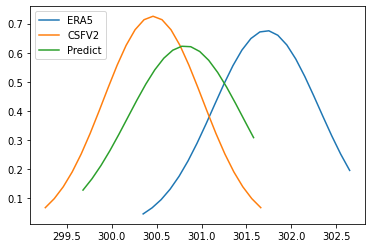

前90天
Point: 0 7
1 4 ERA5: -0.38 CSFV2: 0.04 Predict: -0.09


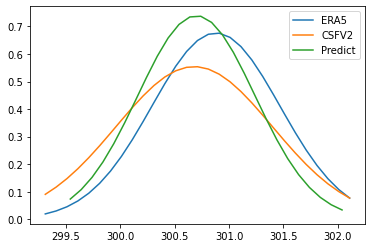

後90天
Point: 0 7
1 9 ERA5: -0.26 CSFV2: -0.1 Predict: -0.63


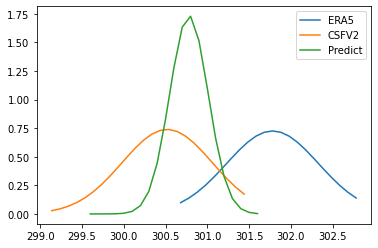

前90天
Point: 0 8
1 4 ERA5: -0.29 CSFV2: -0.04 Predict: -0.48


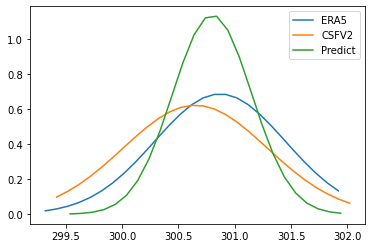

後90天
Point: 0 8
1 9 ERA5: -0.04 CSFV2: -0.12 Predict: -0.32


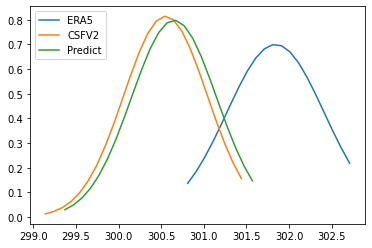

前90天
Point: 0 9
1 4 ERA5: -0.1 CSFV2: -0.38 Predict: -0.17


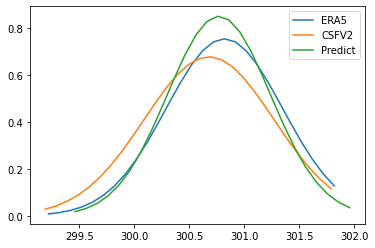

後90天
Point: 0 9
1 9 ERA5: -0.05 CSFV2: -0.34 Predict: -0.18


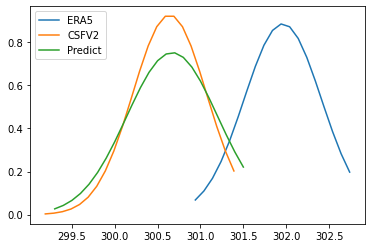

前90天
Point: 0 10
1 4 ERA5: 0.01 CSFV2: -0.28 Predict: -0.07


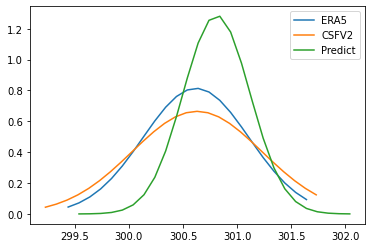

後90天
Point: 0 10
1 9 ERA5: 0.55 CSFV2: -0.23 Predict: -0.15


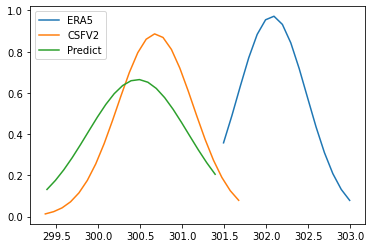

前90天
Point: 0 11
1 4 ERA5: -0.14 CSFV2: -0.52 Predict: -0.39


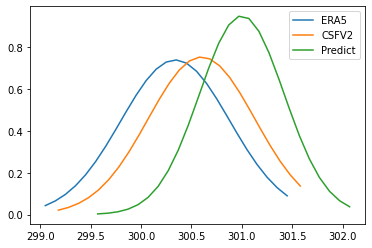

後90天
Point: 0 11
1 9 ERA5: 0.93 CSFV2: -0.49 Predict: 0.1


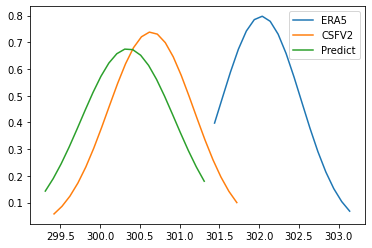

前90天
Point: 0 12
1 4 ERA5: -0.33 CSFV2: -0.8 Predict: -0.75


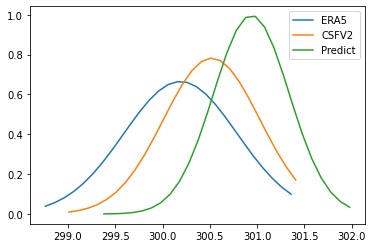

後90天
Point: 0 12
1 9 ERA5: 0.9 CSFV2: -0.66 Predict: 0.19


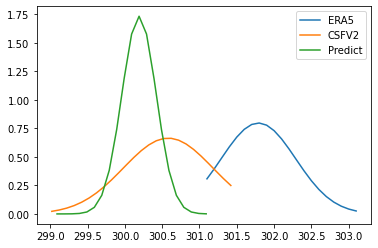

前90天
Point: 0 13
1 4 ERA5: -0.43 CSFV2: -0.85 Predict: -0.54


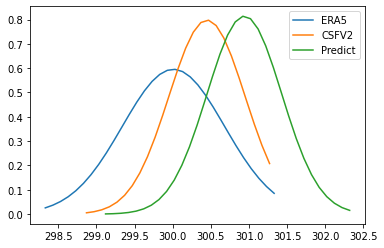

後90天
Point: 0 13
1 9 ERA5: 0.63 CSFV2: -0.83 Predict: -0.58


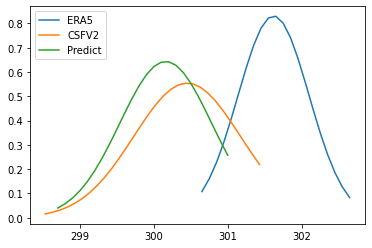

前90天
Point: 0 14
1 4 ERA5: -0.51 CSFV2: -0.47 Predict: -0.86


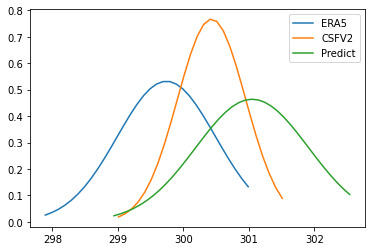

後90天
Point: 0 14
1 9 ERA5: 0.3 CSFV2: -0.91 Predict: -0.43


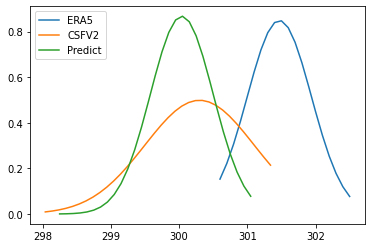

前90天
Point: 0 15
1 4 ERA5: -0.45 CSFV2: 0.23 Predict: -0.63


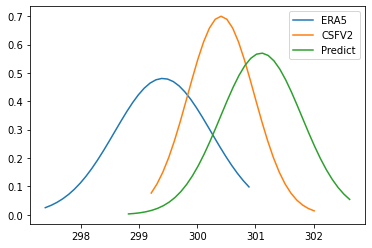

後90天
Point: 0 15
1 9 ERA5: 0.58 CSFV2: -0.86 Predict: -0.24


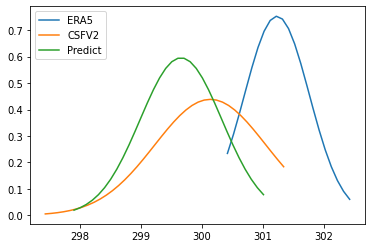

前90天
Point: 0 16
1 4 ERA5: -0.34 CSFV2: 0.98 Predict: -0.39


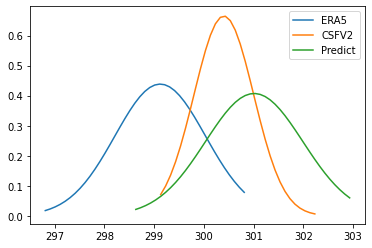

後90天
Point: 0 16
1 9 ERA5: 0.57 CSFV2: -0.83 Predict: -0.3


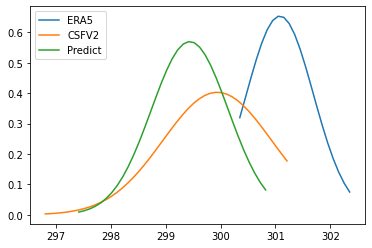

前90天
Point: 0 17
1 4 ERA5: -0.23 CSFV2: 1.44 Predict: -0.43


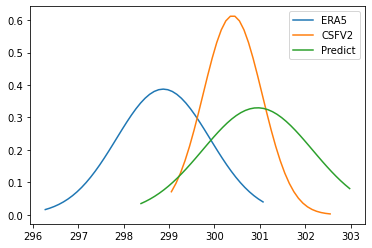

後90天
Point: 0 17
1 9 ERA5: 0.45 CSFV2: -0.89 Predict: -0.41


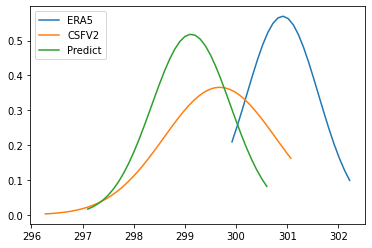

前90天
Point: 0 18
1 4 ERA5: -0.33 CSFV2: 1.68 Predict: -0.37


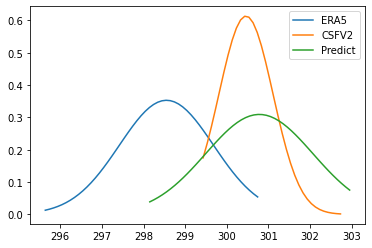

後90天
Point: 0 18
1 9 ERA5: 0.17 CSFV2: -0.87 Predict: -0.39


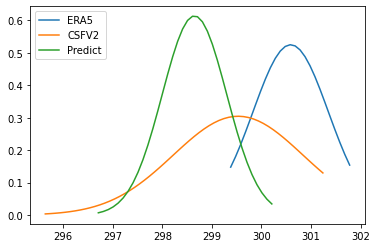

前90天
Point: 0 19
1 4 ERA5: -0.43 CSFV2: 1.55 Predict: -0.19


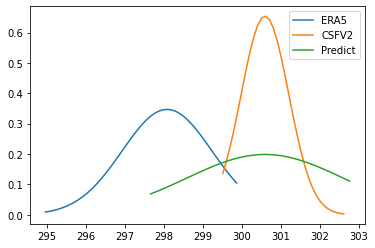

後90天
Point: 0 19
1 9 ERA5: -0.01 CSFV2: -0.8 Predict: -0.29


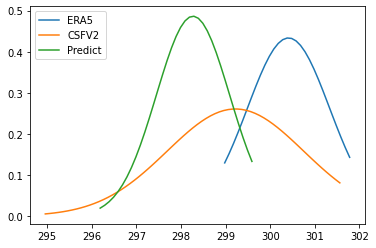

前90天
Point: 0 20
1 4 ERA5: -0.6 CSFV2: 1.38 Predict: -0.17


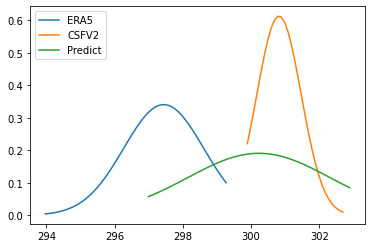

後90天
Point: 0 20
1 9 ERA5: -0.06 CSFV2: -0.67 Predict: -0.67


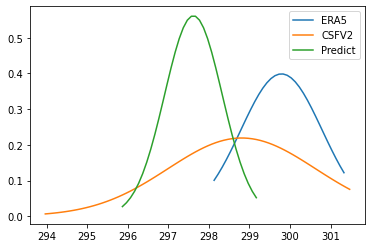

前90天
Point: 0 21
1 4 ERA5: -0.18 CSFV2: 1.09 Predict: -0.01


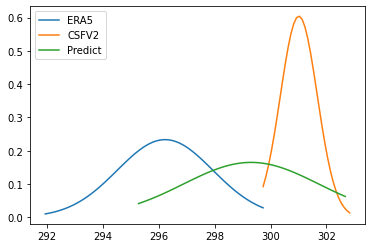

後90天
Point: 0 21
1 9 ERA5: -0.1 CSFV2: -0.33 Predict: -0.7


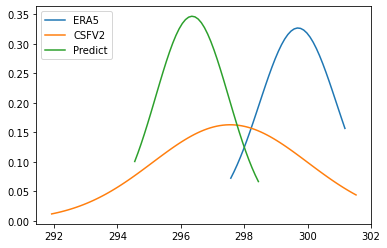

前90天
Point: 0 22
1 4 ERA5: -0.05 CSFV2: -0.87 Predict: -0.27


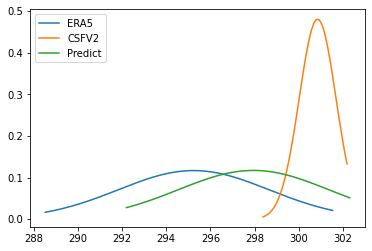

後90天
Point: 0 22
1 9 ERA5: -0.72 CSFV2: -0.09 Predict: 0.01


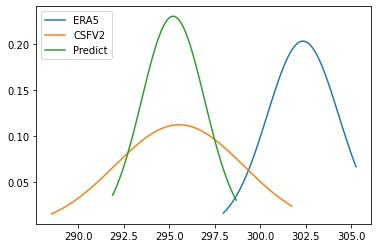

前90天
Point: 0 23
1 4 ERA5: 0.02 CSFV2: -0.65 Predict: -0.5


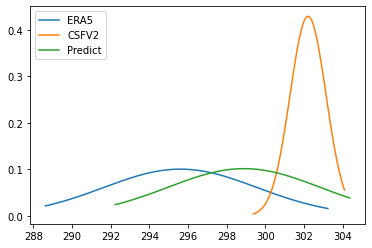

後90天
Point: 0 23
1 9 ERA5: -0.94 CSFV2: 0.2 Predict: -0.21


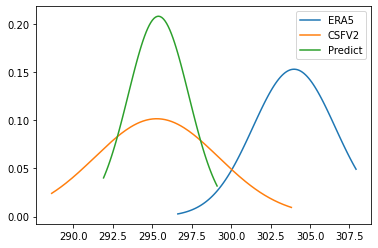

前90天
Point: 0 24
1 4 ERA5: 0.06 CSFV2: -0.34 Predict: -0.31


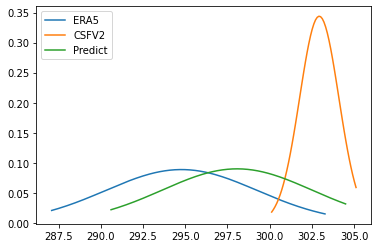

後90天
Point: 0 24
1 9 ERA5: -1.58 CSFV2: 0.36 Predict: -0.09


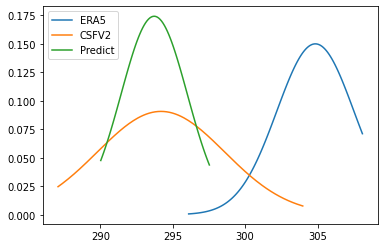

前90天
Point: 0 25
1 4 ERA5: -0.0 CSFV2: -0.06 Predict: -0.33


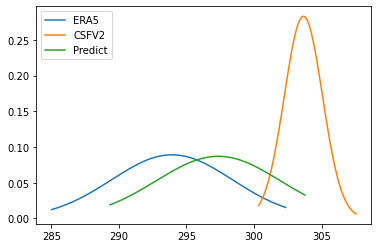

後90天
Point: 0 25
1 9 ERA5: -1.69 CSFV2: 0.36 Predict: -0.49


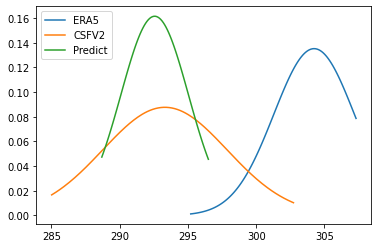

前90天
Point: 0 26
1 4 ERA5: -0.02 CSFV2: -0.29 Predict: -0.18


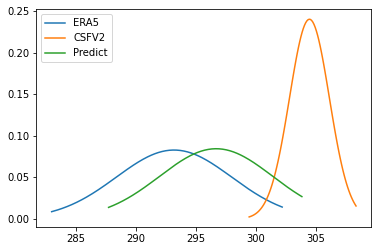

後90天
Point: 0 26
1 9 ERA5: -1.52 CSFV2: 0.4 Predict: -0.21


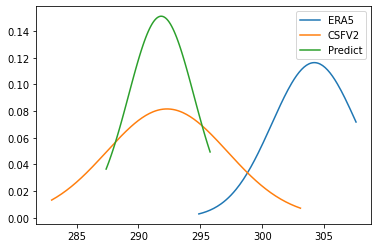

前90天
Point: 0 27
1 4 ERA5: -0.0 CSFV2: -0.72 Predict: -0.25


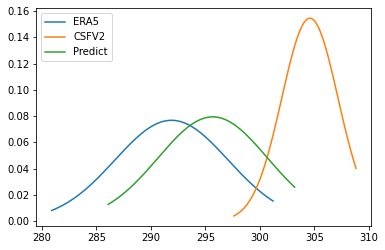

後90天
Point: 0 27
1 9 ERA5: -1.36 CSFV2: 0.5 Predict: 0.07


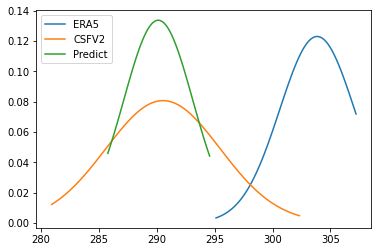

前90天
Point: 0 28
1 4 ERA5: 0.03 CSFV2: -0.64 Predict: 0.04


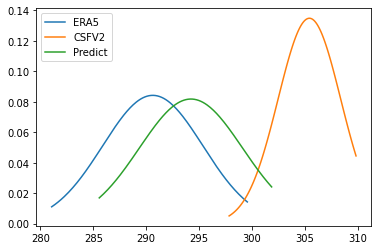

後90天
Point: 0 28
1 9 ERA5: -0.83 CSFV2: 0.49 Predict: -0.11


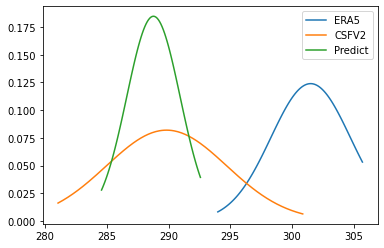

前90天
Point: 0 29
1 4 ERA5: -0.02 CSFV2: -0.62 Predict: -0.06


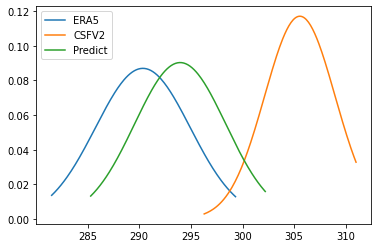

後90天
Point: 0 29
1 9 ERA5: -0.52 CSFV2: 0.41 Predict: -0.31


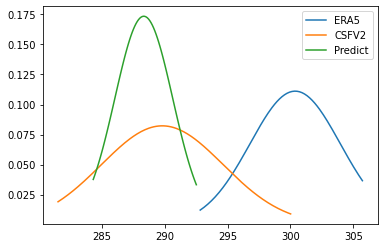

前90天
Point: 0 30
1 4 ERA5: 0.19 CSFV2: -0.78 Predict: 0.17


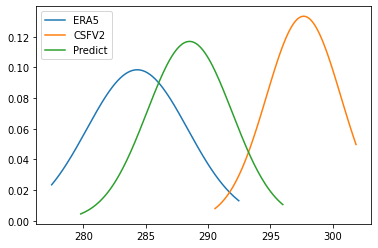

後90天
Point: 0 30
1 9 ERA5: -0.17 CSFV2: 0.52 Predict: -0.44


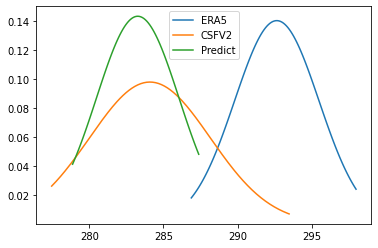

前90天
Point: 0 31
1 4 ERA5: 0.26 CSFV2: -0.84 Predict: 0.43


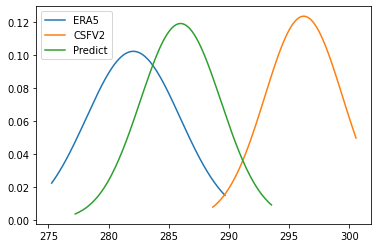

後90天
Point: 0 31
1 9 ERA5: -0.2 CSFV2: 0.55 Predict: -0.6


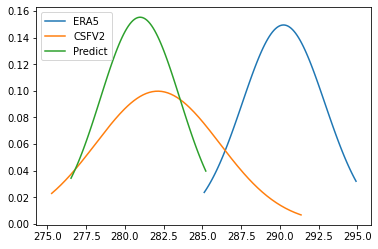

前90天
Point: 0 32
1 4 ERA5: 0.24 CSFV2: -0.66 Predict: 0.69


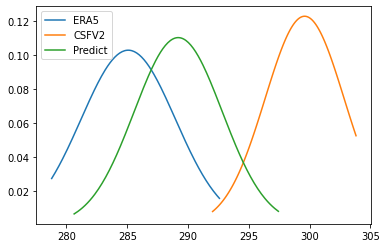

後90天
Point: 0 32
1 9 ERA5: -0.03 CSFV2: 0.53 Predict: -0.79


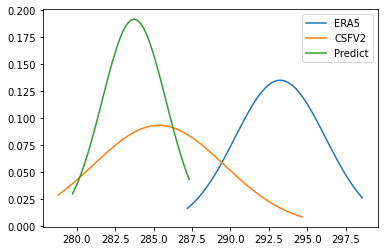

前90天
Point: 0 33
1 4 ERA5: 0.14 CSFV2: -0.74 Predict: 0.31


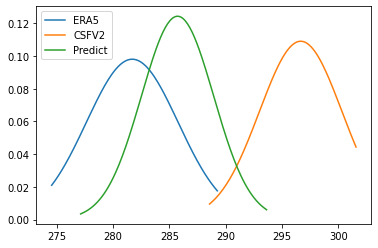

後90天
Point: 0 33
1 9 ERA5: -0.07 CSFV2: 0.28 Predict: -0.55


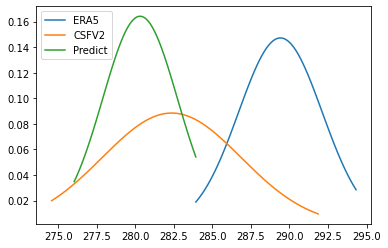

前90天
Point: 0 34
1 4 ERA5: -0.11 CSFV2: -0.76 Predict: -0.1


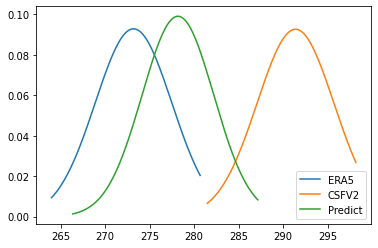

後90天
Point: 0 34
1 9 ERA5: -0.42 CSFV2: -0.07 Predict: -0.11


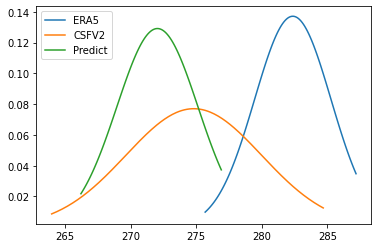

前90天
Point: 0 35
1 4 ERA5: -0.1 CSFV2: -0.82 Predict: -0.05


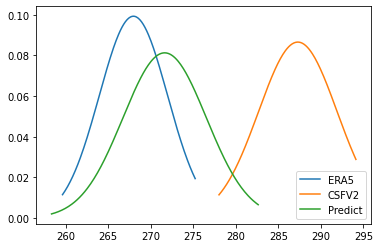

後90天
Point: 0 35
1 9 ERA5: 0.29 CSFV2: 0.3 Predict: -0.56


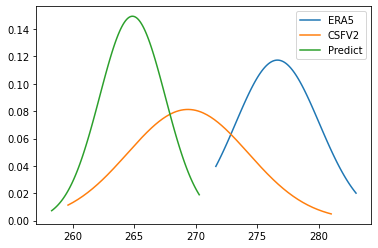

前90天
Point: 0 36
1 4 ERA5: 0.14 CSFV2: -0.67 Predict: -0.09


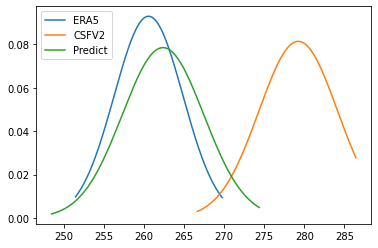

後90天
Point: 0 36
1 9 ERA5: 0.15 CSFV2: 0.67 Predict: 0.32


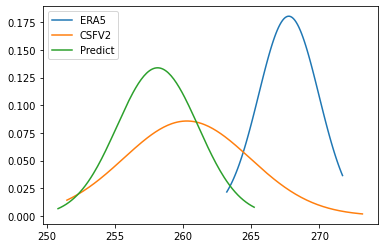

前90天
Point: 0 37
1 4 ERA5: 0.56 CSFV2: -0.08 Predict: -0.55


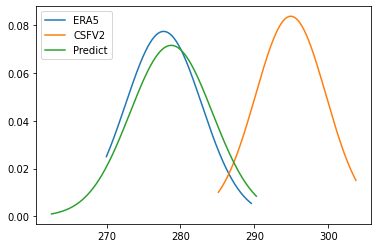

後90天
Point: 0 37
1 9 ERA5: -0.91 CSFV2: 0.47 Predict: 0.06


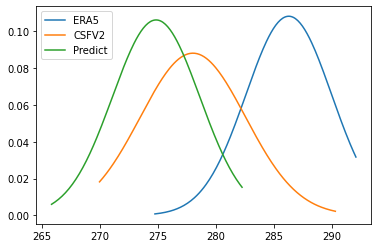

前90天
Point: 0 38
1 4 ERA5: 0.51 CSFV2: -0.15 Predict: -0.61


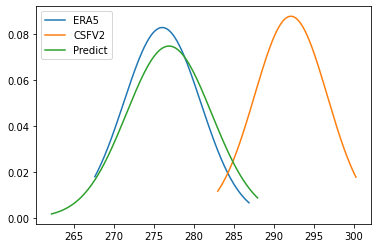

後90天
Point: 0 38
1 9 ERA5: -1.06 CSFV2: 0.37 Predict: -0.02


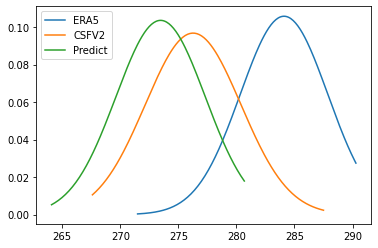

前90天
Point: 0 39
1 4 ERA5: 0.17 CSFV2: -0.4 Predict: -0.05


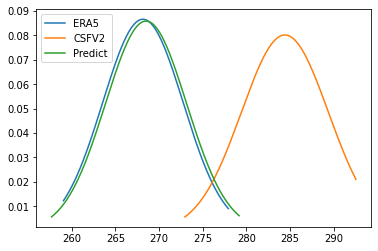

後90天
Point: 0 39
1 9 ERA5: -0.04 CSFV2: 0.71 Predict: -0.32


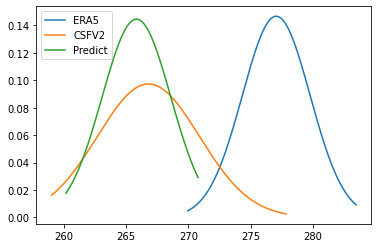

前90天
Point: 0 40
1 4 ERA5: 0.54 CSFV2: -0.07 Predict: -0.15


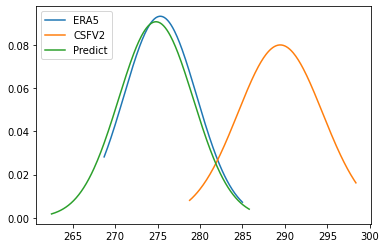

後90天
Point: 0 40
1 9 ERA5: -0.52 CSFV2: 0.64 Predict: 0.13


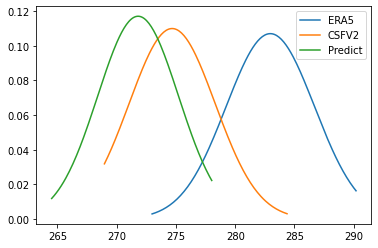

前90天
Point: 0 41
1 4 ERA5: 0.47 CSFV2: 0.13 Predict: -0.07


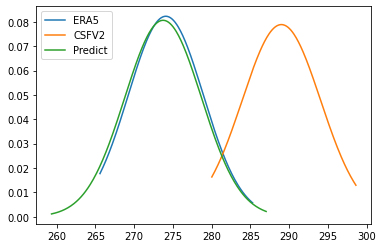

後90天
Point: 0 41
1 9 ERA5: -0.44 CSFV2: 0.35 Predict: 0.34


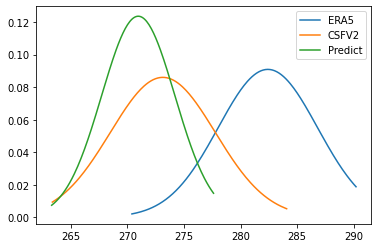

前90天
Point: 0 42
1 4 ERA5: 0.48 CSFV2: 0.08 Predict: -0.03


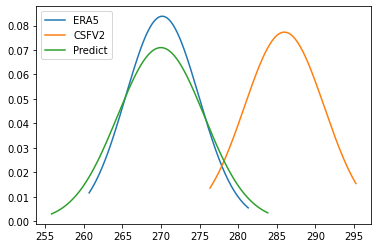

後90天
Point: 0 42
1 9 ERA5: -0.81 CSFV2: 0.28 Predict: 0.28


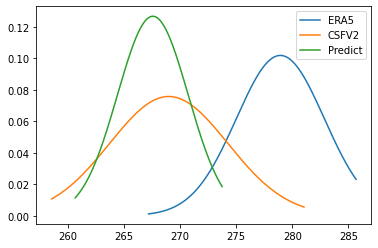

前90天
Point: 0 43
1 4 ERA5: 0.54 CSFV2: 0.07 Predict: -0.37


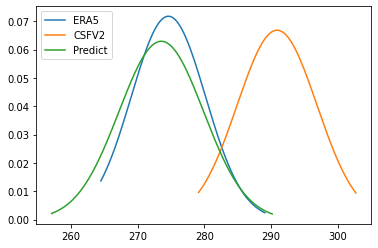

後90天
Point: 0 43
1 9 ERA5: -0.46 CSFV2: 0.44 Predict: 0.42


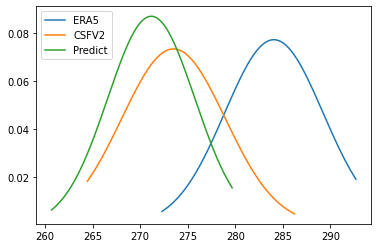

前90天
Point: 0 44
1 4 ERA5: 0.71 CSFV2: -0.05 Predict: 0.09


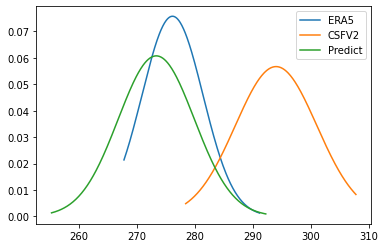

後90天
Point: 0 44
1 9 ERA5: 0.03 CSFV2: 0.85 Predict: 0.56


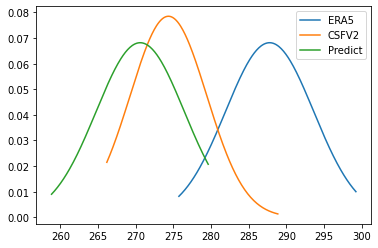

前90天
Point: 0 45
1 4 ERA5: 0.82 CSFV2: -0.07 Predict: -0.21


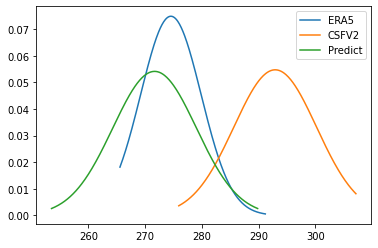

後90天
Point: 0 45
1 9 ERA5: 0.25 CSFV2: 0.76 Predict: 0.4


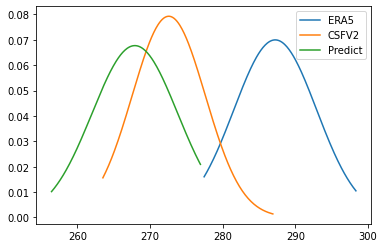

前90天
Point: 0 46
1 4 ERA5: 0.32 CSFV2: -0.1 Predict: -0.24


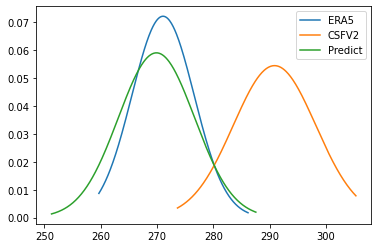

後90天
Point: 0 46
1 9 ERA5: 0.11 CSFV2: 0.54 Predict: 0.24


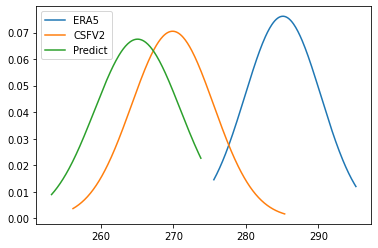

前90天
Point: 0 47
1 4 ERA5: 0.11 CSFV2: -0.16 Predict: -0.28


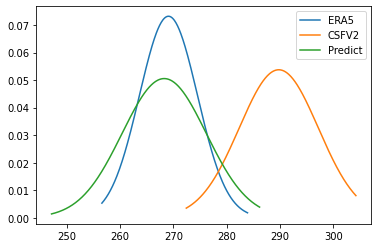

後90天
Point: 0 47
1 9 ERA5: 0.16 CSFV2: 0.28 Predict: 0.39


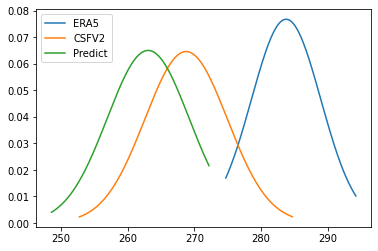

前90天
Point: 0 48
1 4 ERA5: -0.08 CSFV2: -0.15 Predict: -0.32


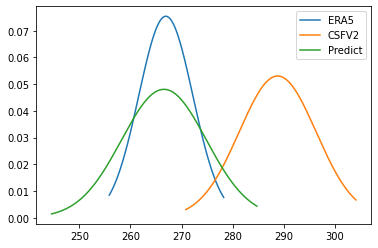

後90天
Point: 0 48
1 9 ERA5: 0.15 CSFV2: 0.31 Predict: -0.23


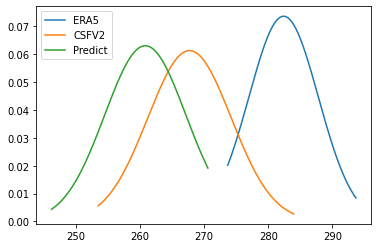

前90天
Point: 0 49
1 4 ERA5: -0.39 CSFV2: -0.14 Predict: -0.21


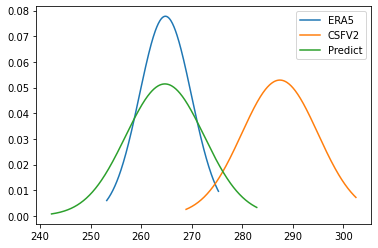

後90天
Point: 0 49
1 9 ERA5: 0.02 CSFV2: 0.44 Predict: 0.31


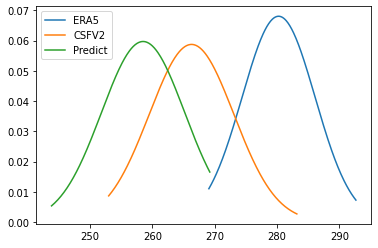

前90天
Point: 0 50
1 4 ERA5: -0.45 CSFV2: -0.13 Predict: -0.33


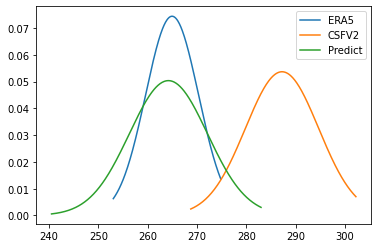

後90天
Point: 0 50
1 9 ERA5: 0.22 CSFV2: 0.39 Predict: 0.4


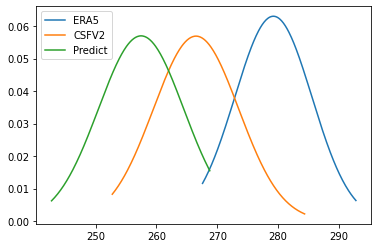

前90天
Point: 0 51
1 4 ERA5: -0.6 CSFV2: -0.12 Predict: -0.45


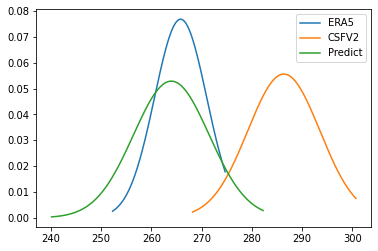

後90天
Point: 0 51
1 9 ERA5: 0.13 CSFV2: 0.1 Predict: 0.07


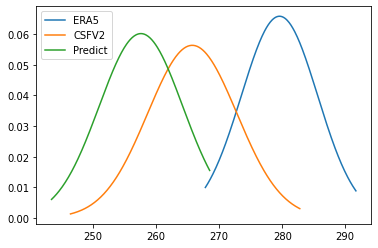

前90天
Point: 0 52
1 4 ERA5: -0.67 CSFV2: -0.17 Predict: -0.35


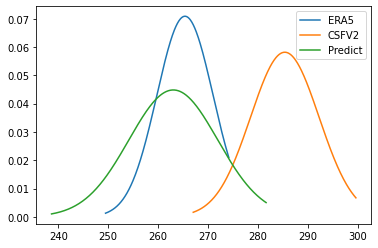

後90天
Point: 0 52
1 9 ERA5: 0.21 CSFV2: 0.16 Predict: 0.09


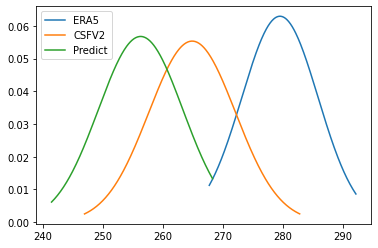

前90天
Point: 0 53
1 4 ERA5: -0.6 CSFV2: -0.37 Predict: -0.31


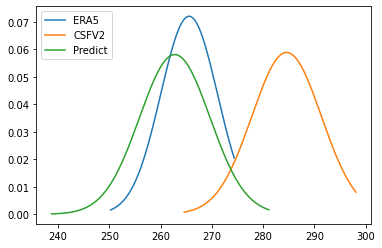

後90天
Point: 0 53
1 9 ERA5: 0.36 CSFV2: 0.43 Predict: 0.08


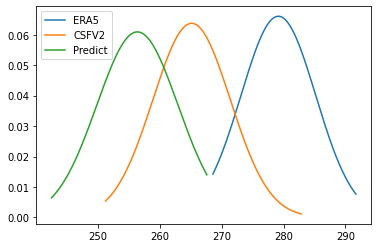

前90天
Point: 0 54
1 4 ERA5: -0.64 CSFV2: -0.34 Predict: -0.35


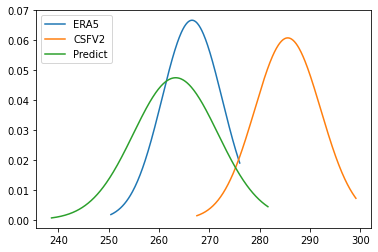

後90天
Point: 0 54
1 9 ERA5: 0.49 CSFV2: 0.35 Predict: -0.12


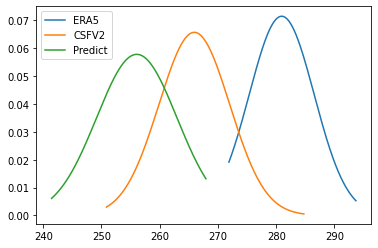

前90天
Point: 0 55
1 4 ERA5: -0.54 CSFV2: -0.44 Predict: -0.49


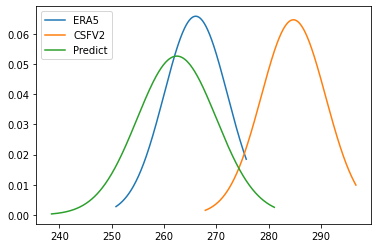

後90天
Point: 0 55
1 9 ERA5: 0.41 CSFV2: 0.18 Predict: -0.03


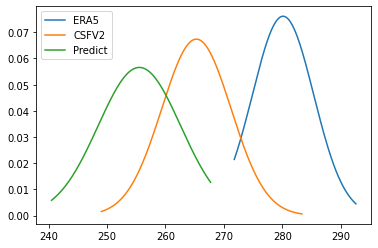

前90天
Point: 0 56
1 4 ERA5: -0.51 CSFV2: -0.51 Predict: -0.66


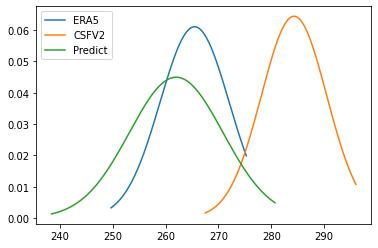

後90天
Point: 0 56
1 9 ERA5: 0.51 CSFV2: 0.04 Predict: -0.16


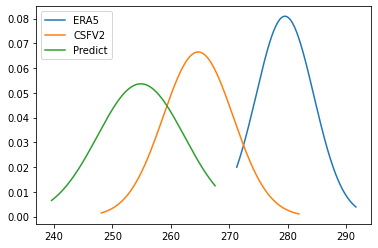

前90天
Point: 0 57
1 4 ERA5: -0.58 CSFV2: -0.49 Predict: -0.49


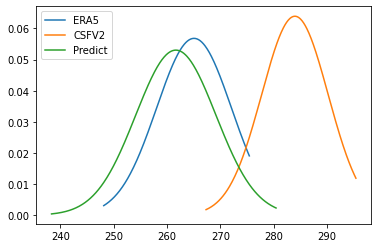

後90天
Point: 0 57
1 9 ERA5: 0.37 CSFV2: -0.23 Predict: 0.08


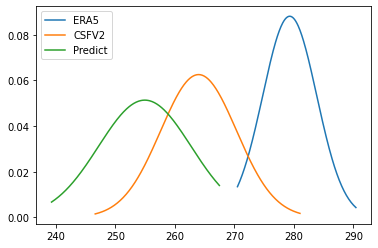

前90天
Point: 0 58
1 4 ERA5: -0.69 CSFV2: -0.44 Predict: -0.43


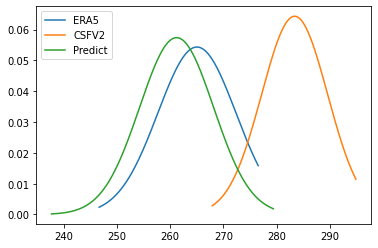

後90天
Point: 0 58
1 9 ERA5: 0.31 CSFV2: -0.44 Predict: -0.09


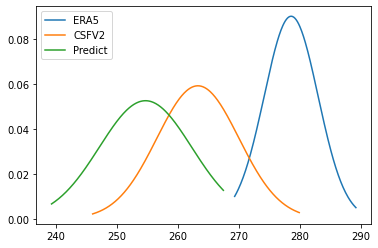

前90天
Point: 0 59
1 4 ERA5: -0.62 CSFV2: -0.42 Predict: -0.46


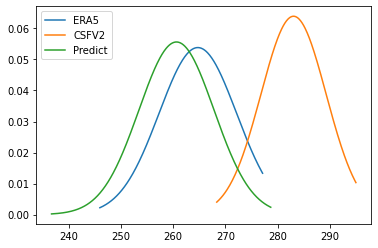

後90天
Point: 0 59
1 9 ERA5: 0.36 CSFV2: -0.41 Predict: 0.1


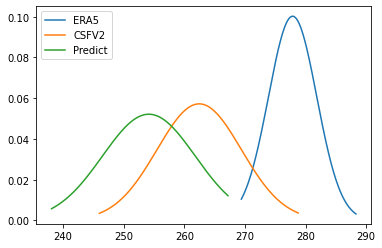

前90天
Point: 0 60
1 4 ERA5: -0.56 CSFV2: -0.37 Predict: -0.61


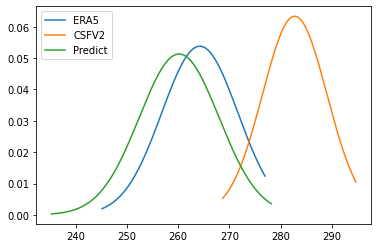

後90天
Point: 0 60
1 9 ERA5: 0.22 CSFV2: -0.39 Predict: -0.3


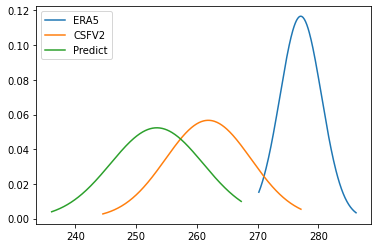

前90天
Point: 0 61
1 4 ERA5: -0.1 CSFV2: -0.2 Predict: 0.29


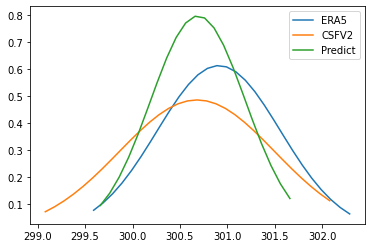

後90天
Point: 0 61
1 9 ERA5: -0.46 CSFV2: 0.48 Predict: -1.05


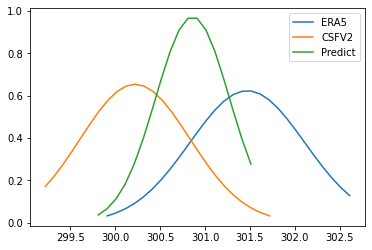

前90天
Point: 0 62
1 4 ERA5: -0.23 CSFV2: -0.14 Predict: 0.24


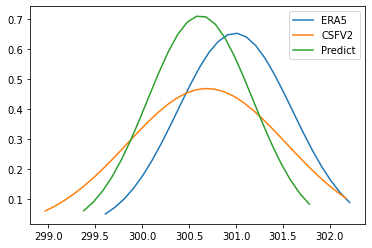

後90天
Point: 0 62
1 9 ERA5: -0.42 CSFV2: 0.39 Predict: -0.99


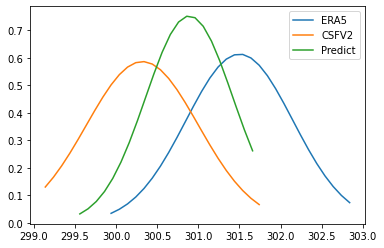

前90天
Point: 0 63
1 4 ERA5: -0.5 CSFV2: -0.14 Predict: 0.29


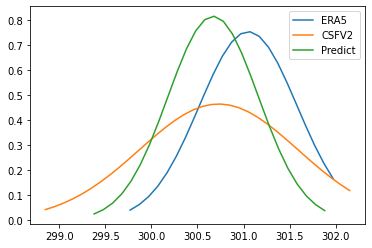

後90天
Point: 0 63
1 9 ERA5: -0.72 CSFV2: 0.07 Predict: -0.79


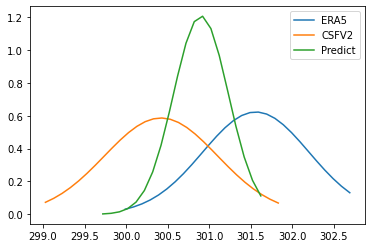

前90天
Point: 0 64
1 4 ERA5: -0.75 CSFV2: -0.14 Predict: 0.5


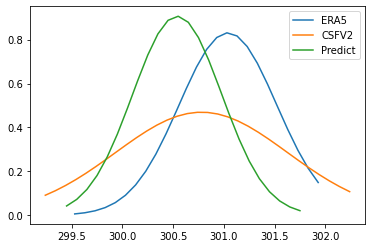

後90天
Point: 0 64
1 9 ERA5: -0.94 CSFV2: -0.06 Predict: -0.96


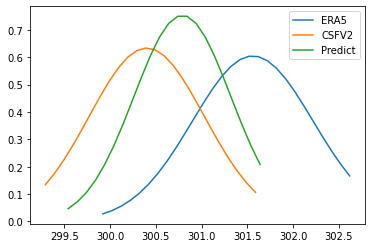

前90天
Point: 0 65
1 4 ERA5: -0.44 CSFV2: -0.2 Predict: 0.51


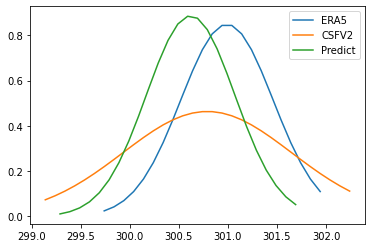

後90天
Point: 0 65
1 9 ERA5: -0.93 CSFV2: 0.0 Predict: -0.81


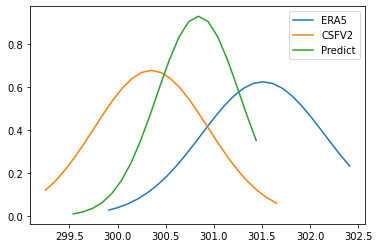

前90天
Point: 0 66
1 4 ERA5: -0.28 CSFV2: -0.23 Predict: 0.19


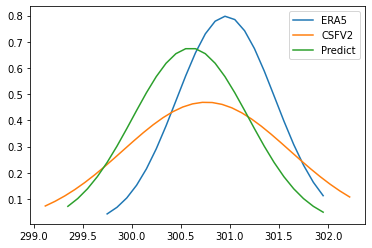

後90天
Point: 0 66
1 9 ERA5: -1.17 CSFV2: 0.11 Predict: -0.93


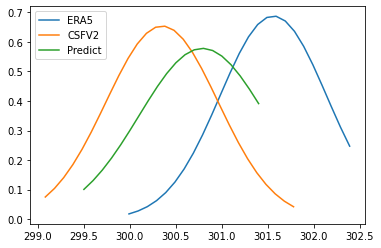

前90天
Point: 0 67
1 4 ERA5: -0.49 CSFV2: -0.18 Predict: -0.02


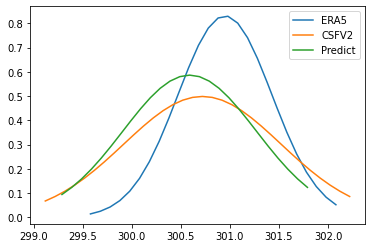

後90天
Point: 0 67
1 9 ERA5: -0.08 CSFV2: -0.04 Predict: -0.58


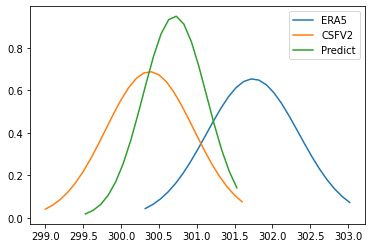

前90天
Point: 0 68
1 4 ERA5: -0.57 CSFV2: 0.01 Predict: -0.0


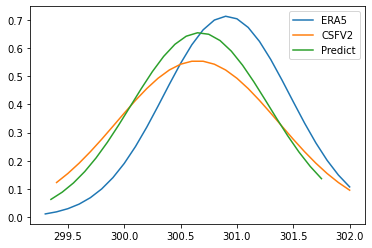

後90天
Point: 0 68
1 9 ERA5: -0.37 CSFV2: -0.3 Predict: -0.87


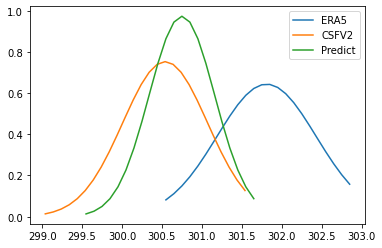

前90天
Point: 0 69
1 4 ERA5: -0.51 CSFV2: 0.07 Predict: -0.31


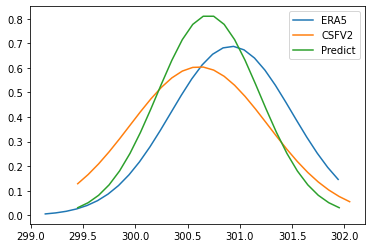

後90天
Point: 0 69
1 9 ERA5: -0.19 CSFV2: -0.59 Predict: -0.29


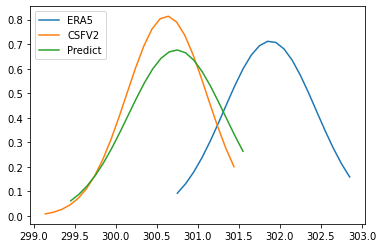

前90天
Point: 0 70
1 4 ERA5: 0.03 CSFV2: -0.24 Predict: -0.23


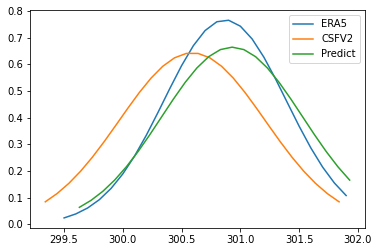

後90天
Point: 0 70
1 9 ERA5: -0.54 CSFV2: -0.73 Predict: -0.18


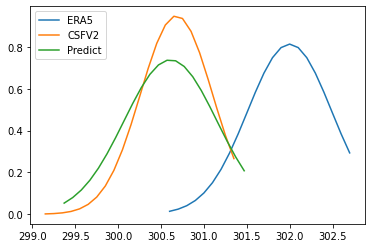

前90天
Point: 0 71
1 4 ERA5: 0.13 CSFV2: -0.22 Predict: -0.18


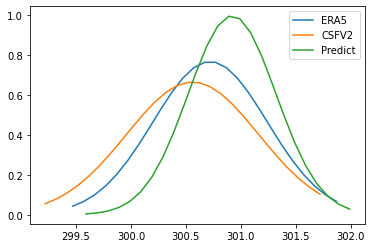

後90天
Point: 0 71
1 9 ERA5: 0.37 CSFV2: -0.29 Predict: -0.3


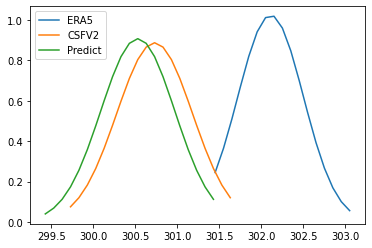

前90天
Point: 0 72
1 4 ERA5: 0.06 CSFV2: -0.49 Predict: -0.42


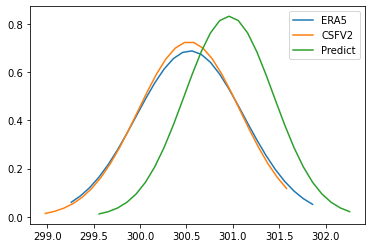

後90天
Point: 0 72
1 9 ERA5: 0.81 CSFV2: -0.2 Predict: -0.06


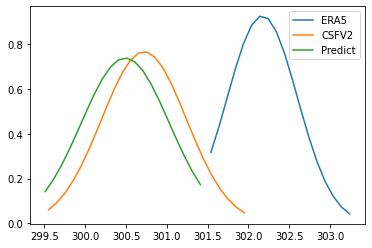

前90天
Point: 0 73
1 4 ERA5: -0.35 CSFV2: -0.57 Predict: -0.54


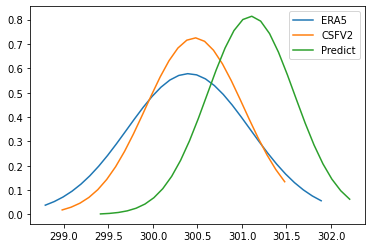

後90天
Point: 0 73
1 9 ERA5: 0.8 CSFV2: -0.8 Predict: 0.5


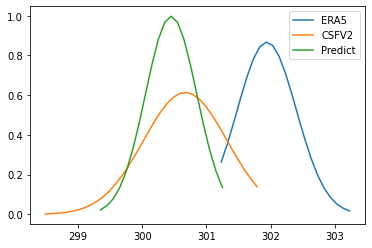

前90天
Point: 0 74
1 4 ERA5: -0.46 CSFV2: -0.51 Predict: -0.56


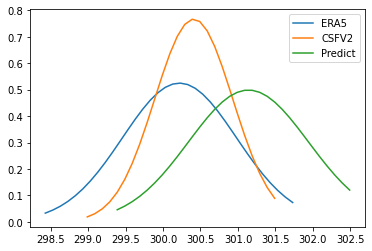

後90天
Point: 0 74
1 9 ERA5: 0.74 CSFV2: -0.78 Predict: -0.27


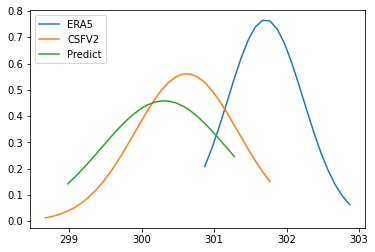

前90天
Point: 0 75
1 4 ERA5: -0.46 CSFV2: -0.12 Predict: -0.63


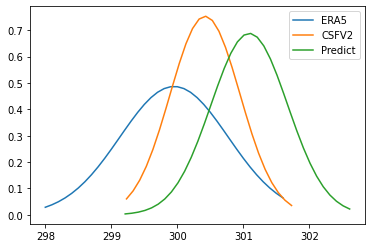

後90天
Point: 0 75
1 9 ERA5: 0.54 CSFV2: -0.86 Predict: -0.28


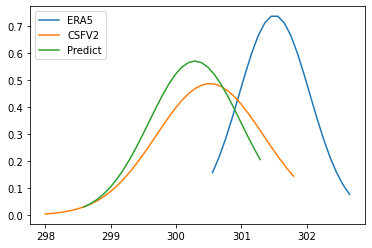

前90天
Point: 0 76
1 4 ERA5: -0.46 CSFV2: 0.2 Predict: -0.57


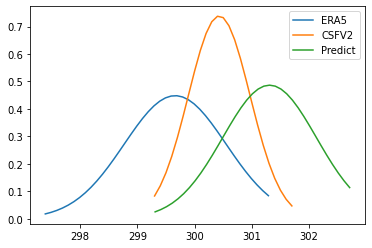

後90天
Point: 0 76
1 9 ERA5: 0.78 CSFV2: -0.8 Predict: -0.26


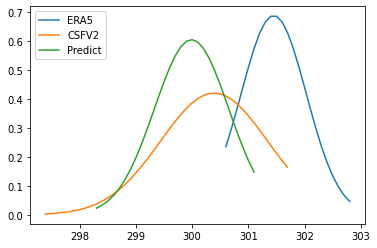

前90天
Point: 0 77
1 4 ERA5: -0.36 CSFV2: 1.08 Predict: -0.42


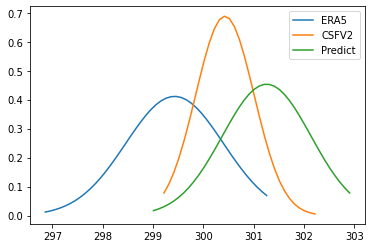

後90天
Point: 0 77
1 9 ERA5: 0.69 CSFV2: -0.79 Predict: -0.35


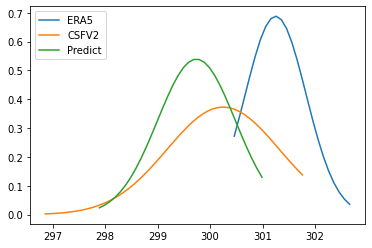

前90天
Point: 0 78
1 4 ERA5: -0.3 CSFV2: 1.75 Predict: -0.52


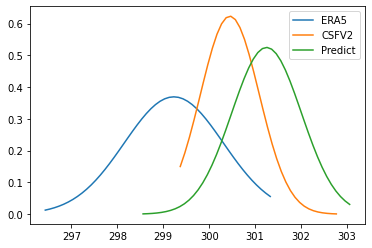

後90天
Point: 0 78
1 9 ERA5: 0.8 CSFV2: -0.81 Predict: -0.21


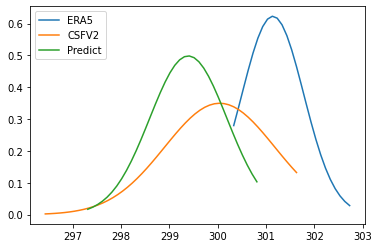

前90天
Point: 0 79
1 4 ERA5: -0.43 CSFV2: 1.96 Predict: -0.5


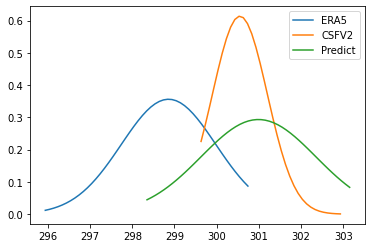

後90天
Point: 0 79
1 9 ERA5: 0.47 CSFV2: -0.91 Predict: -0.27


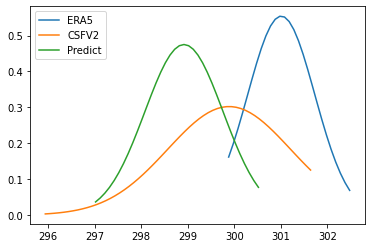

前90天
Point: 0 80
1 4 ERA5: -0.5 CSFV2: 2.01 Predict: -0.42


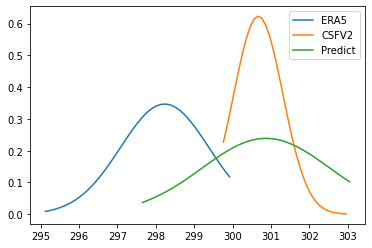

後90天
Point: 0 80
1 9 ERA5: 0.18 CSFV2: -0.78 Predict: -0.63


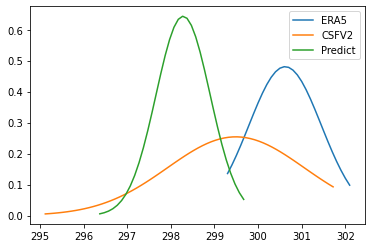

前90天
Point: 0 81
1 4 ERA5: -0.28 CSFV2: 1.52 Predict: 0.0


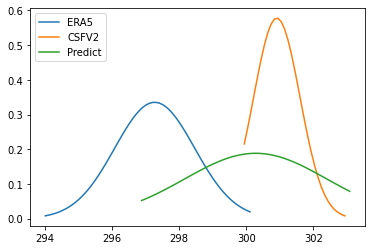

後90天
Point: 0 81
1 9 ERA5: 0.08 CSFV2: -0.52 Predict: -0.85


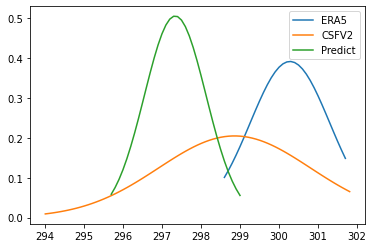

前90天
Point: 0 82
1 4 ERA5: 0.2 CSFV2: -0.36 Predict: -0.19


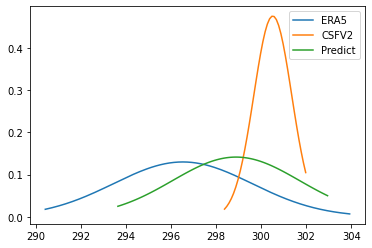

後90天
Point: 0 82
1 9 ERA5: -0.31 CSFV2: -0.35 Predict: -0.62


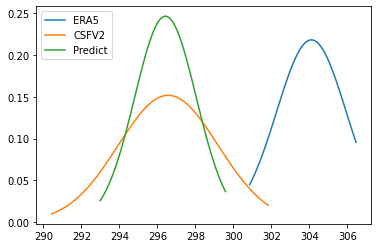

前90天
Point: 0 83
1 4 ERA5: 0.04 CSFV2: -0.62 Predict: -0.45


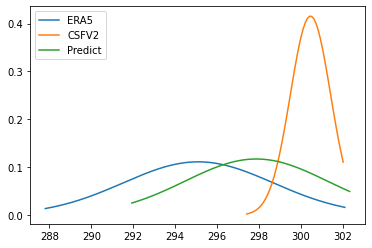

後90天
Point: 0 83
1 9 ERA5: -0.79 CSFV2: -0.12 Predict: 0.16


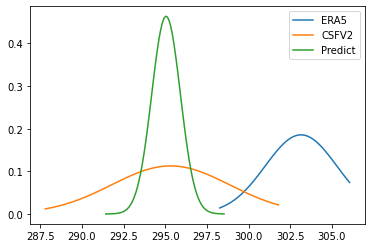

前90天
Point: 0 84
1 4 ERA5: 0.14 CSFV2: -0.96 Predict: -0.38


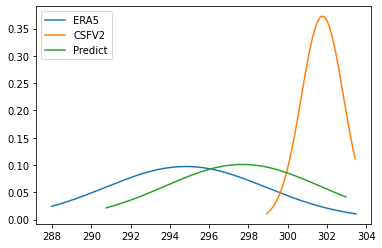

後90天
Point: 0 84
1 9 ERA5: -1.08 CSFV2: 0.12 Predict: -0.3


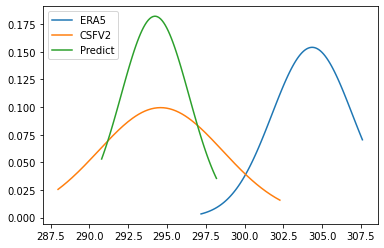

前90天
Point: 0 85
1 4 ERA5: 0.24 CSFV2: -0.88 Predict: -0.04


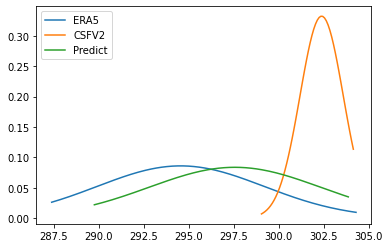

後90天
Point: 0 85
1 9 ERA5: -1.51 CSFV2: 0.22 Predict: -0.45


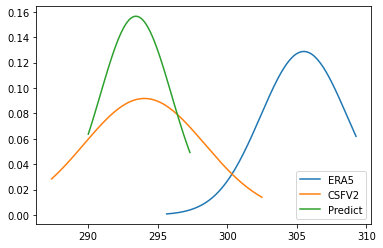

前90天
Point: 0 86
1 4 ERA5: 0.16 CSFV2: -0.12 Predict: -0.2


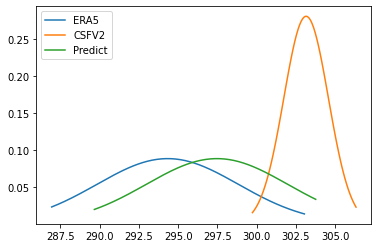

後90天
Point: 0 86
1 9 ERA5: -1.62 CSFV2: 0.37 Predict: -0.21


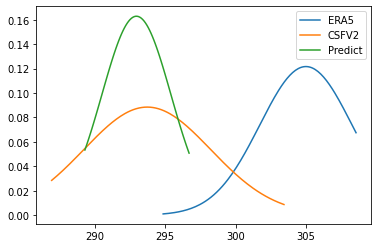

前90天
Point: 0 87
1 4 ERA5: 0.11 CSFV2: -0.35 Predict: -0.34


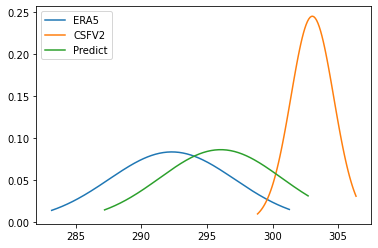

後90天
Point: 0 87
1 9 ERA5: -1.43 CSFV2: 0.42 Predict: -0.18


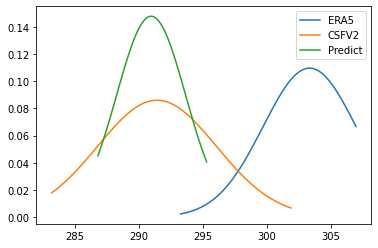

前90天
Point: 0 88
1 4 ERA5: 0.09 CSFV2: -0.59 Predict: -0.05


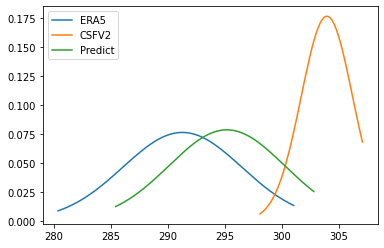

後90天
Point: 0 88
1 9 ERA5: -1.16 CSFV2: 0.56 Predict: -0.11


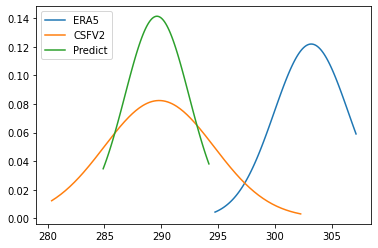

前90天
Point: 0 89
1 4 ERA5: 0.08 CSFV2: -0.55 Predict: 0.27


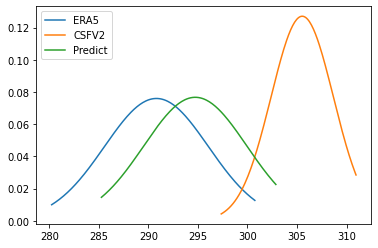

後90天
Point: 0 89
1 9 ERA5: -0.94 CSFV2: 0.56 Predict: -0.05


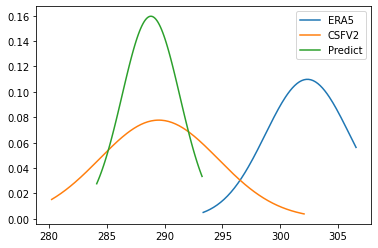

前90天
Point: 0 90
1 4 ERA5: 0.07 CSFV2: -0.61 Predict: 0.16


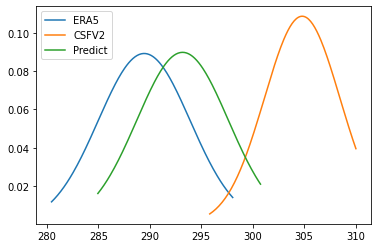

後90天
Point: 0 90
1 9 ERA5: -0.53 CSFV2: 0.44 Predict: -0.17


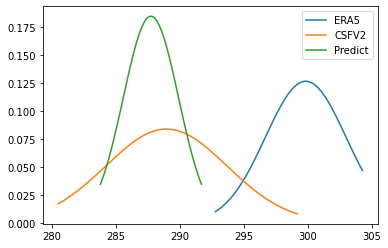

前90天
Point: 0 91
1 4 ERA5: 0.03 CSFV2: -0.54 Predict: 0.16


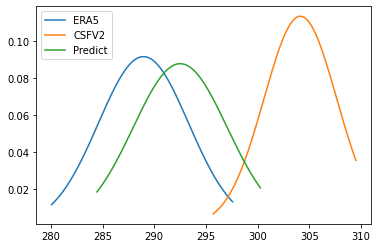

後90天
Point: 0 91
1 9 ERA5: -0.38 CSFV2: 0.37 Predict: -0.42


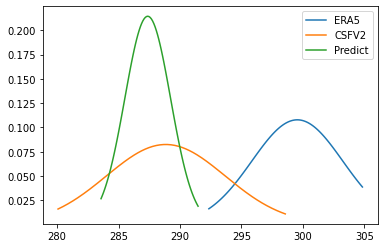

前90天
Point: 0 92
1 4 ERA5: -0.02 CSFV2: -0.53 Predict: 0.14


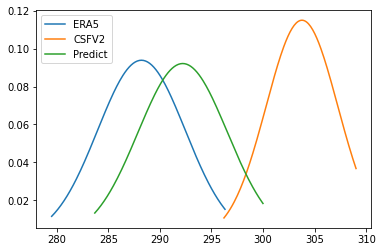

後90天
Point: 0 92
1 9 ERA5: -0.21 CSFV2: 0.4 Predict: -0.72


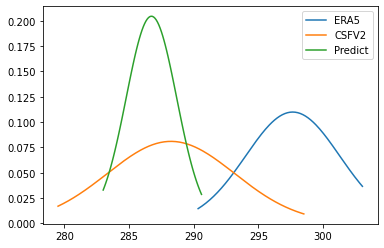

前90天
Point: 0 93
1 4 ERA5: -0.01 CSFV2: -0.59 Predict: 0.31


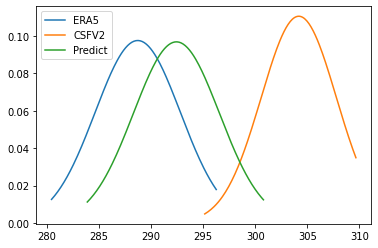

後90天
Point: 0 93
1 9 ERA5: -0.2 CSFV2: 0.49 Predict: -0.73


KeyboardInterrupt: 

In [30]:
#單點作圖PDF
Pic=0
for data in y_predict:
    for i in range(len(data)):
        for j in range(len(data[0])):
            
            #前90天
            print('前90天')
            PDF_point(i, j, data, 0, 5, Pic)
            
            #後90天
            print('後90天')
            PDF_point(i, j, data, 5, 10, Pic)
            
        Pic=Pic+1

前90天
1 X_90 ERA5: 282.42 CSFV2: 293.46 Predict: 283.69
1 Y_90 ERA5: 3.2 CSFV2: 3.08 Predict: 3.96
1 Mean_90 ERA5: 289.56 CSFV2: 298.55 Predict: 291.77
1 STD_90 ERA5: 275.33 CSFV2: 285.99 Predict: 274.95
1 Maximum_90 ERA5: -0.08 CSFV2: -0.38 Predict: -0.1


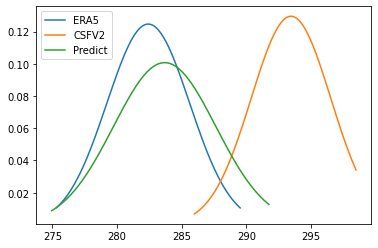

後90天
1 Minimum_90 ERA5: 288.23 CSFV2: 282.84 Predict: 280.16
1 Skewness_90 ERA5: 2.16 CSFV2: 3.59 Predict: 2.65
1 X_180 ERA5: 292.26 CSFV2: 290.75 Predict: 284.91
1 Y_180 ERA5: 283.92 CSFV2: 275.77 Predict: 275.39
1 Mean_180 ERA5: -0.11 CSFV2: 0.15 Predict: -0.14


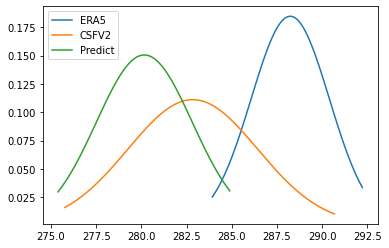

前90天
2 X_90 ERA5: 282.49 CSFV2: 287.44 Predict: 281.39
2 Y_90 ERA5: 3.19 CSFV2: 4.52 Predict: 2.84
2 Mean_90 ERA5: 289.61 CSFV2: 295.65 Predict: 288.18
2 STD_90 ERA5: 275.42 CSFV2: 278.06 Predict: 274.73
2 Maximum_90 ERA5: -0.08 CSFV2: -0.21 Predict: -0.03


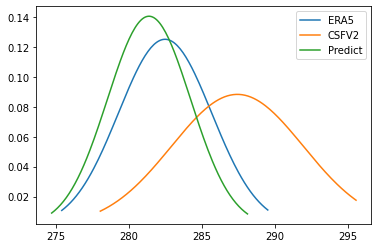

後90天
2 Minimum_90 ERA5: 288.35 CSFV2: 281.72 Predict: 285.75
2 Skewness_90 ERA5: 2.12 CSFV2: 2.86 Predict: 2.63
2 X_180 ERA5: 292.37 CSFV2: 287.93 Predict: 290.25
2 Y_180 ERA5: 284.24 CSFV2: 275.24 Predict: 280.91
2 Mean_180 ERA5: -0.09 CSFV2: -0.07 Predict: -0.24


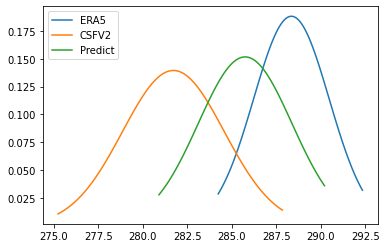

前90天
3 X_90 ERA5: 282.31 CSFV2: 285.78 Predict: 281.83
3 Y_90 ERA5: 3.25 CSFV2: 4.44 Predict: 3.22
3 Mean_90 ERA5: 289.72 CSFV2: 294.32 Predict: 288.98
3 STD_90 ERA5: 275.57 CSFV2: 276.91 Predict: 274.48
3 Maximum_90 ERA5: 0.13 CSFV2: -0.11 Predict: -0.06


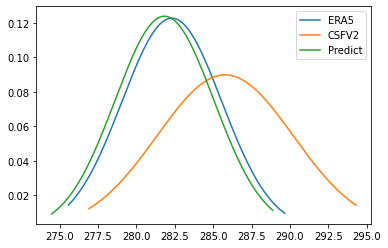

後90天
3 Minimum_90 ERA5: 282.03 CSFV2: 282.49 Predict: 287.44
3 Skewness_90 ERA5: 2.58 CSFV2: 3.19 Predict: 2.48
3 X_180 ERA5: 286.57 CSFV2: 289.61 Predict: 291.74
3 Y_180 ERA5: 276.67 CSFV2: 275.42 Predict: 282.73
3 Mean_180 ERA5: -0.25 CSFV2: -0.08 Predict: -0.24


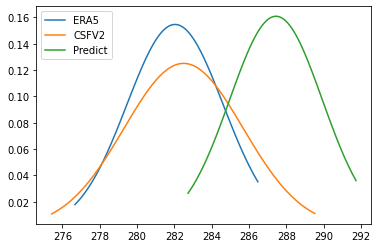

前90天
4 X_90 ERA5: 285.35 CSFV2: 292.65 Predict: 282.61
4 Y_90 ERA5: 4.41 CSFV2: 3.23 Predict: 3.59
4 Mean_90 ERA5: 293.59 CSFV2: 298.1 Predict: 290.33
4 STD_90 ERA5: 276.26 CSFV2: 285.32 Predict: 274.55
4 Maximum_90 ERA5: -0.14 CSFV2: -0.25 Predict: -0.07


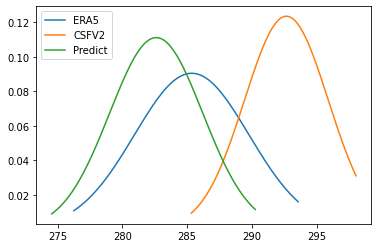

後90天
4 Minimum_90 ERA5: 280.94 CSFV2: 282.05 Predict: 280.74
4 Skewness_90 ERA5: 2.04 CSFV2: 3.1 Predict: 2.67
4 X_180 ERA5: 284.7 CSFV2: 289.24 Predict: 285.5
4 Y_180 ERA5: 276.91 CSFV2: 275.52 Predict: 275.94
4 Mean_180 ERA5: -0.16 CSFV2: 0.12 Predict: -0.16


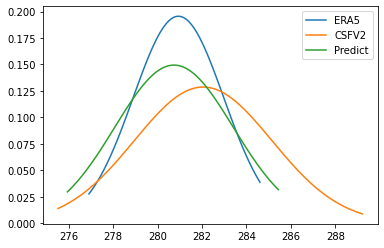

前90天
5 X_90 ERA5: 281.36 CSFV2: 289.27 Predict: 281.13
5 Y_90 ERA5: 2.64 CSFV2: 4.42 Predict: 2.79
5 Mean_90 ERA5: 287.49 CSFV2: 296.87 Predict: 287.97
5 STD_90 ERA5: 275.15 CSFV2: 279.33 Predict: 274.56
5 Maximum_90 ERA5: -0.04 CSFV2: -0.27 Predict: -0.01


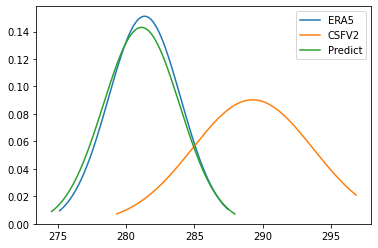

後90天
5 Minimum_90 ERA5: 284.64 CSFV2: 281.44 Predict: 284.41
5 Skewness_90 ERA5: 2.2 CSFV2: 2.72 Predict: 2.7
5 X_180 ERA5: 288.82 CSFV2: 287.54 Predict: 289.04
5 Y_180 ERA5: 280.31 CSFV2: 275.14 Predict: 279.53
5 Mean_180 ERA5: -0.1 CSFV2: -0.05 Predict: -0.23


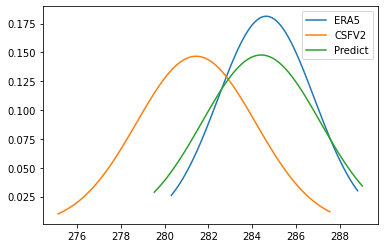

前90天
6 X_90 ERA5: 282.75 CSFV2: 286.64 Predict: 281.76
6 Y_90 ERA5: 3.55 CSFV2: 4.5 Predict: 2.99
6 Mean_90 ERA5: 290.72 CSFV2: 295.16 Predict: 288.67
6 STD_90 ERA5: 275.71 CSFV2: 277.54 Predict: 274.79
6 Maximum_90 ERA5: 0.16 CSFV2: -0.15 Predict: -0.04


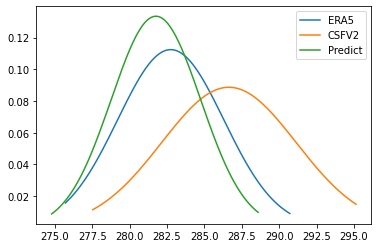

後90天
6 Minimum_90 ERA5: 281.6 CSFV2: 282.06 Predict: 286.68
6 Skewness_90 ERA5: 2.59 CSFV2: 3.06 Predict: 2.55
6 X_180 ERA5: 286.41 CSFV2: 288.93 Predict: 291.08
6 Y_180 ERA5: 276.45 CSFV2: 275.25 Predict: 281.89
6 Mean_180 ERA5: -0.15 CSFV2: -0.06 Predict: -0.25


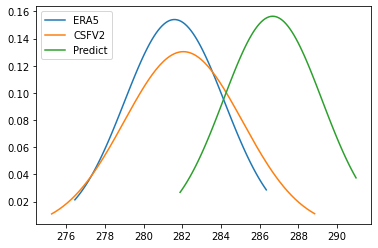

前90天
7 X_90 ERA5: 284.16 CSFV2: 291.17 Predict: 281.6
7 Y_90 ERA5: 4.07 CSFV2: 3.85 Predict: 2.95
7 Mean_90 ERA5: 292.0 CSFV2: 297.46 Predict: 288.6
7 STD_90 ERA5: 275.99 CSFV2: 281.36 Predict: 274.7
7 Maximum_90 ERA5: -0.05 CSFV2: -0.29 Predict: -0.03


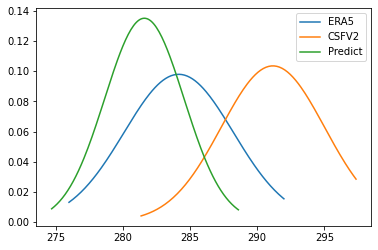

後90天
7 Minimum_90 ERA5: 280.65 CSFV2: 281.45 Predict: 282.72
7 Skewness_90 ERA5: 2.2 CSFV2: 2.74 Predict: 2.71
7 X_180 ERA5: 284.97 CSFV2: 287.97 Predict: 287.42
7 Y_180 ERA5: 276.22 CSFV2: 275.12 Predict: 277.85
7 Mean_180 ERA5: -0.16 CSFV2: 0.02 Predict: -0.2


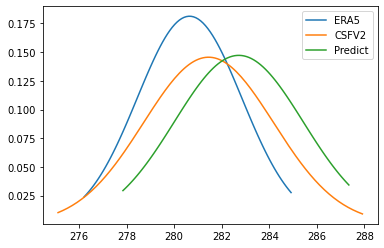

前90天
8 X_90 ERA5: 281.49 CSFV2: 290.39 Predict: 281.3
8 Y_90 ERA5: 2.79 CSFV2: 4.16 Predict: 2.87
8 Mean_90 ERA5: 288.13 CSFV2: 297.31 Predict: 288.22
8 STD_90 ERA5: 275.14 CSFV2: 280.38 Predict: 274.58
8 Maximum_90 ERA5: 0.04 CSFV2: -0.28 Predict: -0.02


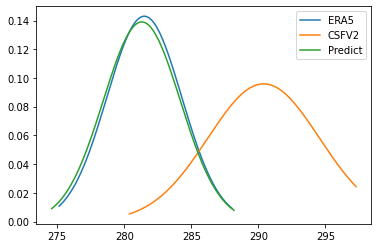

後90天
8 Minimum_90 ERA5: 283.52 CSFV2: 281.36 Predict: 283.48
8 Skewness_90 ERA5: 2.07 CSFV2: 2.64 Predict: 2.71
8 X_180 ERA5: 287.39 CSFV2: 287.49 Predict: 288.15
8 Y_180 ERA5: 279.08 CSFV2: 275.15 Predict: 278.6
8 Mean_180 ERA5: -0.27 CSFV2: -0.04 Predict: -0.22


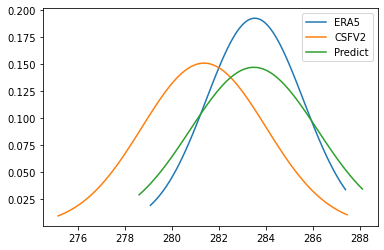

前90天
9 X_90 ERA5: 281.61 CSFV2: 292.94 Predict: 282.83
9 Y_90 ERA5: 2.79 CSFV2: 3.17 Predict: 3.66
9 Mean_90 ERA5: 287.71 CSFV2: 298.34 Predict: 290.62
9 STD_90 ERA5: 275.21 CSFV2: 285.71 Predict: 274.64
9 Maximum_90 ERA5: -0.08 CSFV2: -0.28 Predict: -0.08


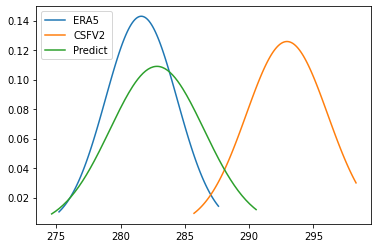

後90天
9 Minimum_90 ERA5: 286.62 CSFV2: 282.31 Predict: 280.53
9 Skewness_90 ERA5: 2.24 CSFV2: 3.25 Predict: 2.67
9 X_180 ERA5: 290.43 CSFV2: 289.72 Predict: 285.28
9 Y_180 ERA5: 281.84 CSFV2: 275.57 Predict: 275.73
9 Mean_180 ERA5: -0.33 CSFV2: 0.13 Predict: -0.15


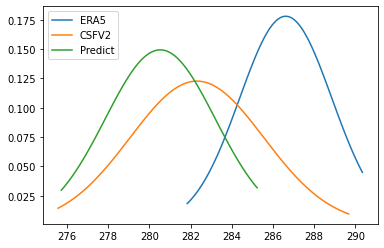

前90天
10 X_90 ERA5: 284.06 CSFV2: 292.34 Predict: 282.62
10 Y_90 ERA5: 4.06 CSFV2: 3.32 Predict: 3.53
10 Mean_90 ERA5: 291.88 CSFV2: 297.91 Predict: 290.27
10 STD_90 ERA5: 275.98 CSFV2: 284.67 Predict: 274.64
10 Maximum_90 ERA5: -0.03 CSFV2: -0.25 Predict: -0.07


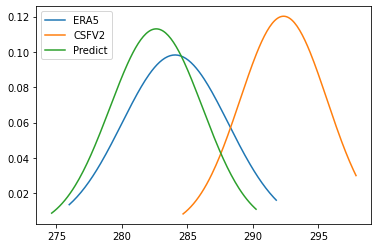

後90天
10 Minimum_90 ERA5: 280.72 CSFV2: 281.81 Predict: 280.86
10 Skewness_90 ERA5: 2.26 CSFV2: 2.98 Predict: 2.68
10 X_180 ERA5: 285.26 CSFV2: 288.94 Predict: 285.61
10 Y_180 ERA5: 276.24 CSFV2: 275.35 Predict: 276.04
10 Mean_180 ERA5: -0.12 CSFV2: 0.12 Predict: -0.16


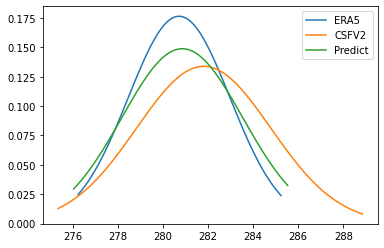

前90天
11 X_90 ERA5: 283.36 CSFV2: 291.91 Predict: 282.05
11 Y_90 ERA5: 3.8 CSFV2: 3.47 Predict: 3.25
11 Mean_90 ERA5: 291.17 CSFV2: 297.7 Predict: 289.44
11 STD_90 ERA5: 275.88 CSFV2: 283.7 Predict: 274.6
11 Maximum_90 ERA5: 0.06 CSFV2: -0.25 Predict: -0.04


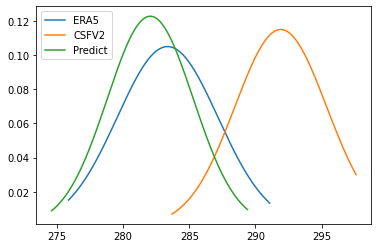

後90天
11 Minimum_90 ERA5: 281.07 CSFV2: 281.59 Predict: 281.66
11 Skewness_90 ERA5: 2.5 CSFV2: 2.84 Predict: 2.69
11 X_180 ERA5: 286.1 CSFV2: 288.19 Predict: 286.41
11 Y_180 ERA5: 276.28 CSFV2: 275.22 Predict: 276.81
11 Mean_180 ERA5: -0.05 CSFV2: 0.06 Predict: -0.18


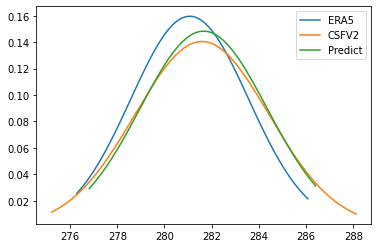

前90天
12 X_90 ERA5: 281.51 CSFV2: 286.92 Predict: 281.74
12 Y_90 ERA5: 2.81 CSFV2: 4.51 Predict: 2.93
12 Mean_90 ERA5: 288.23 CSFV2: 295.41 Predict: 288.61
12 STD_90 ERA5: 275.15 CSFV2: 277.73 Predict: 274.85
12 Maximum_90 ERA5: 0.06 CSFV2: -0.17 Predict: -0.04


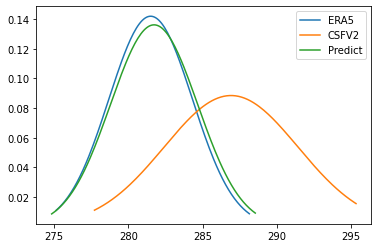

後90天
12 Minimum_90 ERA5: 283.43 CSFV2: 281.93 Predict: 286.02
12 Skewness_90 ERA5: 2.06 CSFV2: 3.0 Predict: 2.59
12 X_180 ERA5: 287.22 CSFV2: 288.77 Predict: 290.48
12 Y_180 ERA5: 279.0 CSFV2: 275.25 Predict: 281.19
12 Mean_180 ERA5: -0.29 CSFV2: -0.06 Predict: -0.24


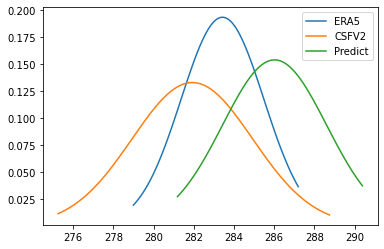

前90天
13 X_90 ERA5: 281.65 CSFV2: 294.87 Predict: 285.73
13 Y_90 ERA5: 2.8 CSFV2: 2.31 Predict: 4.32
13 Mean_90 ERA5: 287.67 CSFV2: 298.93 Predict: 293.94
13 STD_90 ERA5: 275.22 CSFV2: 288.87 Predict: 276.21
13 Maximum_90 ERA5: -0.09 CSFV2: -0.42 Predict: -0.18


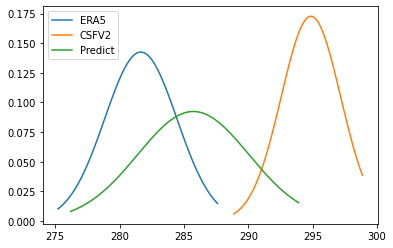

後90天
13 Minimum_90 ERA5: 286.86 CSFV2: 284.79 Predict: 279.92
13 Skewness_90 ERA5: 2.18 CSFV2: 4.28 Predict: 2.58
13 X_180 ERA5: 290.61 CSFV2: 292.96 Predict: 284.59
13 Y_180 ERA5: 282.05 CSFV2: 276.12 Predict: 275.2
13 Mean_180 ERA5: -0.36 CSFV2: -0.1 Predict: -0.12


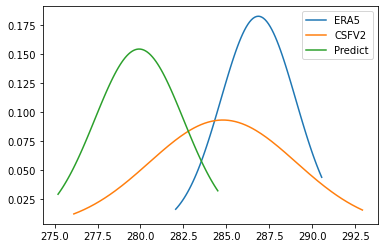

前90天
14 X_90 ERA5: 281.56 CSFV2: 295.14 Predict: 286.5
14 Y_90 ERA5: 2.76 CSFV2: 2.12 Predict: 4.33
14 Mean_90 ERA5: 287.51 CSFV2: 299.0 Predict: 294.6
14 STD_90 ERA5: 275.18 CSFV2: 289.84 Predict: 276.92
14 Maximum_90 ERA5: -0.1 CSFV2: -0.36 Predict: -0.2


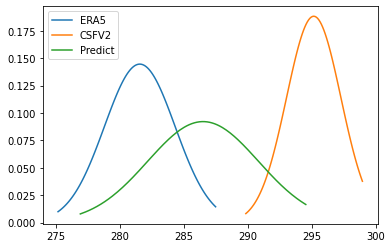

後90天
14 Minimum_90 ERA5: 286.21 CSFV2: 285.49 Predict: 280.22
14 Skewness_90 ERA5: 2.34 CSFV2: 4.43 Predict: 2.57
14 X_180 ERA5: 290.17 CSFV2: 293.93 Predict: 284.86
14 Y_180 ERA5: 281.27 CSFV2: 276.4 Predict: 275.49
14 Mean_180 ERA5: -0.29 CSFV2: -0.13 Predict: -0.13


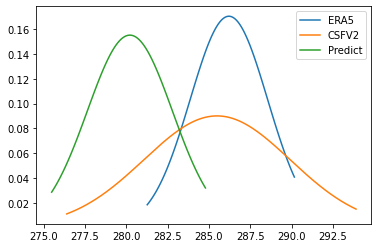

前90天
15 X_90 ERA5: 283.09 CSFV2: 293.72 Predict: 283.85
15 Y_90 ERA5: 3.7 CSFV2: 2.96 Predict: 3.95
15 Mean_90 ERA5: 290.92 CSFV2: 298.67 Predict: 291.91
15 STD_90 ERA5: 275.83 CSFV2: 286.37 Predict: 275.1
15 Maximum_90 ERA5: 0.11 CSFV2: -0.4 Predict: -0.11


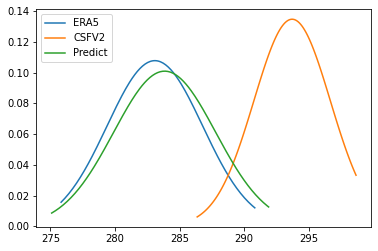

後90天
15 Minimum_90 ERA5: 281.26 CSFV2: 283.09 Predict: 280.16
15 Skewness_90 ERA5: 2.53 CSFV2: 3.7 Predict: 2.65
15 X_180 ERA5: 286.16 CSFV2: 290.92 Predict: 284.91
15 Y_180 ERA5: 276.31 CSFV2: 275.83 Predict: 275.39
15 Mean_180 ERA5: -0.11 CSFV2: 0.11 Predict: -0.14


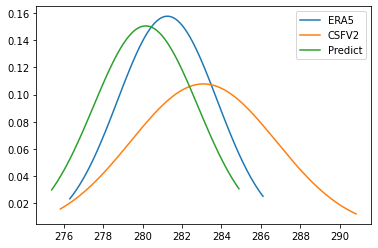

前90天
16 X_90 ERA5: 284.58 CSFV2: 293.03 Predict: 283.1
16 Y_90 ERA5: 4.2 CSFV2: 3.16 Predict: 3.71
16 Mean_90 ERA5: 292.69 CSFV2: 298.4 Predict: 290.94
16 STD_90 ERA5: 276.04 CSFV2: 285.77 Predict: 274.79
16 Maximum_90 ERA5: -0.09 CSFV2: -0.3 Predict: -0.08


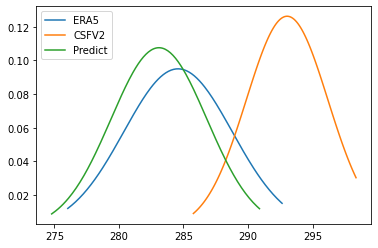

後90天
16 Minimum_90 ERA5: 280.62 CSFV2: 282.4 Predict: 280.47
16 Skewness_90 ERA5: 2.1 CSFV2: 3.31 Predict: 2.66
16 X_180 ERA5: 284.52 CSFV2: 289.98 Predict: 285.23
16 Y_180 ERA5: 276.35 CSFV2: 275.62 Predict: 275.68
16 Mean_180 ERA5: -0.21 CSFV2: 0.15 Predict: -0.15


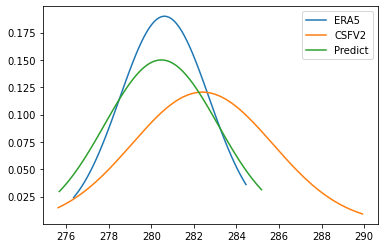

前90天
17 X_90 ERA5: 281.41 CSFV2: 294.67 Predict: 285.21
17 Y_90 ERA5: 2.72 CSFV2: 2.41 Predict: 4.26
17 Mean_90 ERA5: 287.95 CSFV2: 298.9 Predict: 293.43
17 STD_90 ERA5: 275.09 CSFV2: 288.44 Predict: 275.83
17 Maximum_90 ERA5: 0.01 CSFV2: -0.38 Predict: -0.16


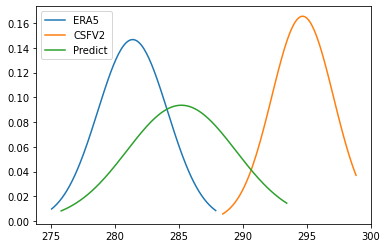

後90天
17 Minimum_90 ERA5: 284.06 CSFV2: 284.37 Predict: 279.82
17 Skewness_90 ERA5: 2.13 CSFV2: 4.12 Predict: 2.59
17 X_180 ERA5: 288.4 CSFV2: 292.34 Predict: 284.52
17 Y_180 ERA5: 279.87 CSFV2: 276.01 Predict: 275.09
17 Mean_180 ERA5: -0.08 CSFV2: -0.08 Predict: -0.13


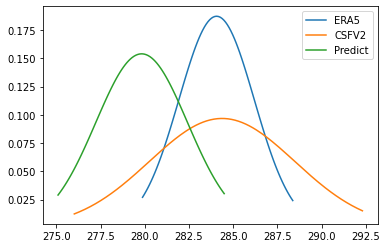

前90天
18 X_90 ERA5: 281.45 CSFV2: 294.6 Predict: 285.1
18 Y_90 ERA5: 2.74 CSFV2: 2.45 Predict: 4.23
18 Mean_90 ERA5: 287.97 CSFV2: 298.89 Predict: 293.32
18 STD_90 ERA5: 275.12 CSFV2: 288.22 Predict: 275.76
18 Maximum_90 ERA5: 0.02 CSFV2: -0.38 Predict: -0.15


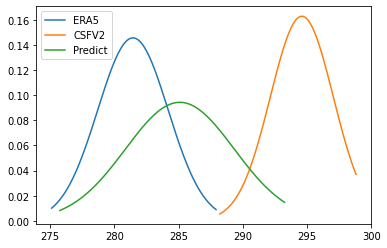

後90天
18 Minimum_90 ERA5: 283.77 CSFV2: 284.26 Predict: 279.89
18 Skewness_90 ERA5: 2.09 CSFV2: 4.09 Predict: 2.6
18 X_180 ERA5: 287.94 CSFV2: 292.16 Predict: 284.6
18 Y_180 ERA5: 279.47 CSFV2: 276.01 Predict: 275.15
18 Mean_180 ERA5: -0.16 CSFV2: -0.06 Predict: -0.13


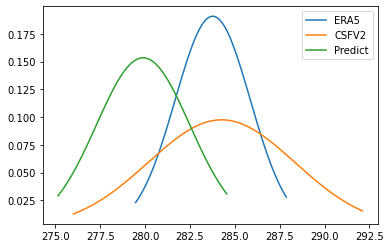

前90天
19 X_90 ERA5: 281.48 CSFV2: 287.31 Predict: 281.43
19 Y_90 ERA5: 2.72 CSFV2: 4.51 Predict: 2.9
19 Mean_90 ERA5: 287.48 CSFV2: 295.59 Predict: 288.28
19 STD_90 ERA5: 275.16 CSFV2: 277.99 Predict: 274.65
19 Maximum_90 ERA5: -0.08 CSFV2: -0.2 Predict: -0.03


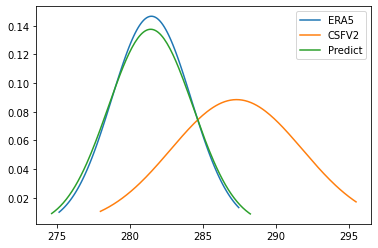

後90天
19 Minimum_90 ERA5: 285.69 CSFV2: 281.76 Predict: 286.24
19 Skewness_90 ERA5: 2.36 CSFV2: 2.89 Predict: 2.59
19 X_180 ERA5: 289.83 CSFV2: 288.15 Predict: 290.69
19 Y_180 ERA5: 280.9 CSFV2: 275.24 Predict: 281.42
19 Mean_180 ERA5: -0.21 CSFV2: -0.06 Predict: -0.24


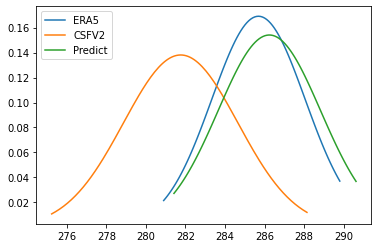

前90天
20 X_90 ERA5: 281.4 CSFV2: 294.92 Predict: 285.91
20 Y_90 ERA5: 2.71 CSFV2: 2.29 Predict: 4.33
20 Mean_90 ERA5: 287.91 CSFV2: 298.95 Predict: 294.1
20 STD_90 ERA5: 275.11 CSFV2: 288.92 Predict: 276.36
20 Maximum_90 ERA5: 0.01 CSFV2: -0.42 Predict: -0.18


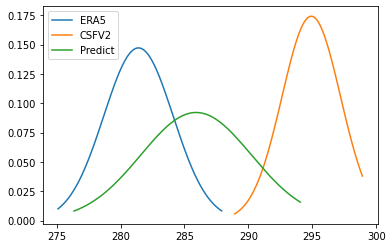

後90天
20 Minimum_90 ERA5: 284.2 CSFV2: 284.9 Predict: 279.97
20 Skewness_90 ERA5: 2.13 CSFV2: 4.32 Predict: 2.57
20 X_180 ERA5: 288.47 CSFV2: 293.04 Predict: 284.63
20 Y_180 ERA5: 280.04 CSFV2: 276.14 Predict: 275.24
20 Mean_180 ERA5: -0.07 CSFV2: -0.11 Predict: -0.13


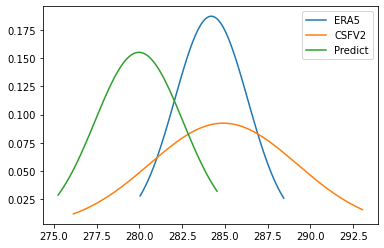

前90天
21 X_90 ERA5: 284.47 CSFV2: 285.92 Predict: 281.88
21 Y_90 ERA5: 4.16 CSFV2: 4.45 Predict: 3.19
21 Mean_90 ERA5: 292.52 CSFV2: 294.45 Predict: 288.98
21 STD_90 ERA5: 276.03 CSFV2: 277.09 Predict: 274.56
21 Maximum_90 ERA5: -0.09 CSFV2: -0.11 Predict: -0.06


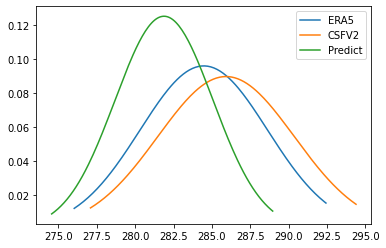

後90天
21 Minimum_90 ERA5: 280.59 CSFV2: 282.42 Predict: 287.45
21 Skewness_90 ERA5: 2.1 CSFV2: 3.2 Predict: 2.48
21 X_180 ERA5: 284.48 CSFV2: 289.56 Predict: 291.74
21 Y_180 ERA5: 276.27 CSFV2: 275.33 Predict: 282.75
21 Mean_180 ERA5: -0.23 CSFV2: -0.08 Predict: -0.24


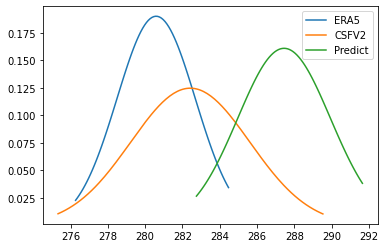

前90天
22 X_90 ERA5: 281.5 CSFV2: 294.03 Predict: 284.22
22 Y_90 ERA5: 2.73 CSFV2: 2.78 Predict: 4.11
22 Mean_90 ERA5: 287.49 CSFV2: 298.74 Predict: 292.44
22 STD_90 ERA5: 275.16 CSFV2: 287.05 Predict: 275.14
22 Maximum_90 ERA5: -0.09 CSFV2: -0.41 Predict: -0.12


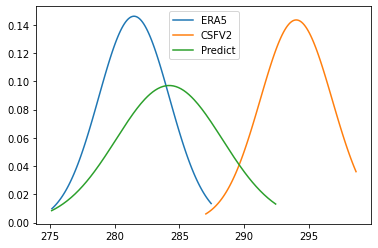

後90天
22 Minimum_90 ERA5: 285.83 CSFV2: 283.46 Predict: 279.94
22 Skewness_90 ERA5: 2.36 CSFV2: 3.84 Predict: 2.62
22 X_180 ERA5: 289.96 CSFV2: 291.31 Predict: 284.68
22 Y_180 ERA5: 281.02 CSFV2: 275.91 Predict: 275.19
22 Mean_180 ERA5: -0.23 CSFV2: 0.05 Predict: -0.13


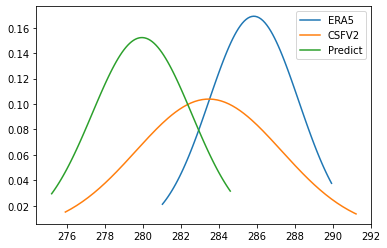

前90天
23 X_90 ERA5: 282.66 CSFV2: 293.28 Predict: 283.6
23 Y_90 ERA5: 3.5 CSFV2: 3.13 Predict: 3.88
23 Mean_90 ERA5: 290.6 CSFV2: 298.49 Predict: 291.58
23 STD_90 ERA5: 275.66 CSFV2: 285.85 Predict: 274.98
23 Maximum_90 ERA5: 0.16 CSFV2: -0.35 Predict: -0.1


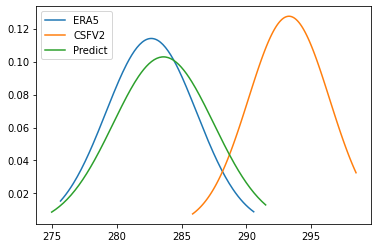

後90天
23 Minimum_90 ERA5: 281.68 CSFV2: 282.66 Predict: 280.23
23 Skewness_90 ERA5: 2.59 CSFV2: 3.5 Predict: 2.65
23 X_180 ERA5: 286.46 CSFV2: 290.6 Predict: 284.98
23 Y_180 ERA5: 276.48 CSFV2: 275.66 Predict: 275.45
23 Mean_180 ERA5: -0.17 CSFV2: 0.16 Predict: -0.14


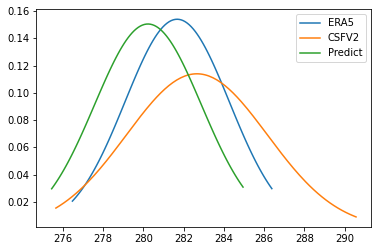

前90天
24 X_90 ERA5: 281.54 CSFV2: 294.72 Predict: 285.21
24 Y_90 ERA5: 2.75 CSFV2: 2.38 Predict: 4.31
24 Mean_90 ERA5: 287.49 CSFV2: 298.9 Predict: 293.48
24 STD_90 ERA5: 275.17 CSFV2: 288.65 Predict: 275.75
24 Maximum_90 ERA5: -0.1 CSFV2: -0.39 Predict: -0.16


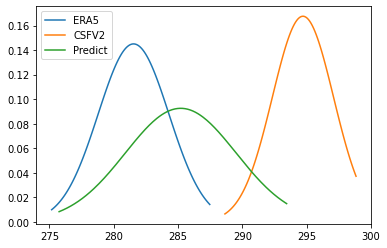

後90天
24 Minimum_90 ERA5: 286.08 CSFV2: 284.47 Predict: 279.73
24 Skewness_90 ERA5: 2.35 CSFV2: 4.16 Predict: 2.59
24 X_180 ERA5: 290.11 CSFV2: 292.52 Predict: 284.42
24 Y_180 ERA5: 281.16 CSFV2: 276.03 Predict: 275.01
24 Mean_180 ERA5: -0.27 CSFV2: -0.09 Predict: -0.12


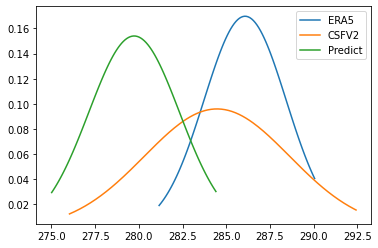

前90天
25 X_90 ERA5: 281.63 CSFV2: 291.29 Predict: 281.64
25 Y_90 ERA5: 2.79 CSFV2: 3.78 Predict: 3.07
25 Mean_90 ERA5: 287.68 CSFV2: 297.48 Predict: 288.79
25 STD_90 ERA5: 275.22 CSFV2: 281.76 Predict: 274.52
25 Maximum_90 ERA5: -0.08 CSFV2: -0.28 Predict: -0.03


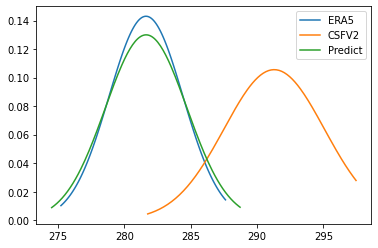

後90天
25 Minimum_90 ERA5: 286.74 CSFV2: 281.47 Predict: 282.41
25 Skewness_90 ERA5: 2.21 CSFV2: 2.76 Predict: 2.7
25 X_180 ERA5: 290.51 CSFV2: 288.02 Predict: 287.12
25 Y_180 ERA5: 281.91 CSFV2: 275.13 Predict: 277.55
25 Mean_180 ERA5: -0.35 CSFV2: 0.02 Predict: -0.2


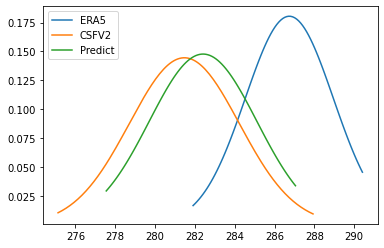

前90天
26 X_90 ERA5: 284.69 CSFV2: 294.1 Predict: 284.33
26 Y_90 ERA5: 4.24 CSFV2: 2.74 Predict: 4.14
26 Mean_90 ERA5: 292.85 CSFV2: 298.75 Predict: 292.58
26 STD_90 ERA5: 276.08 CSFV2: 287.18 Predict: 275.19
26 Maximum_90 ERA5: -0.1 CSFV2: -0.42 Predict: -0.13


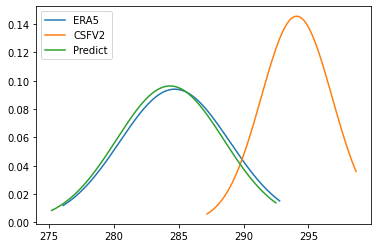

後90天
26 Minimum_90 ERA5: 280.67 CSFV2: 283.55 Predict: 279.92
26 Skewness_90 ERA5: 2.1 CSFV2: 3.88 Predict: 2.61
26 X_180 ERA5: 284.61 CSFV2: 291.43 Predict: 284.67
26 Y_180 ERA5: 276.48 CSFV2: 275.92 Predict: 275.17
26 Mean_180 ERA5: -0.17 CSFV2: 0.04 Predict: -0.13


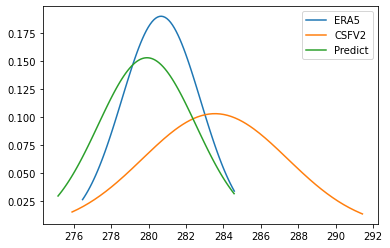

前90天
27 X_90 ERA5: 283.55 CSFV2: 288.55 Predict: 281.32
27 Y_90 ERA5: 3.88 CSFV2: 4.53 Predict: 2.79
27 Mean_90 ERA5: 291.43 CSFV2: 296.49 Predict: 288.11
27 STD_90 ERA5: 275.92 CSFV2: 278.44 Predict: 274.73
27 Maximum_90 ERA5: 0.04 CSFV2: -0.31 Predict: -0.02


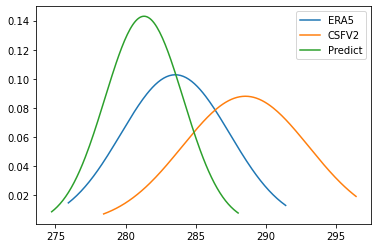

後90天
27 Minimum_90 ERA5: 281.0 CSFV2: 281.54 Predict: 285.05
27 Skewness_90 ERA5: 2.47 CSFV2: 2.75 Predict: 2.67
27 X_180 ERA5: 286.05 CSFV2: 287.49 Predict: 289.62
27 Y_180 ERA5: 276.28 CSFV2: 275.17 Predict: 280.19
27 Mean_180 ERA5: -0.03 CSFV2: -0.1 Predict: -0.24


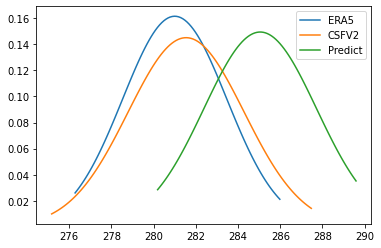

前90天
28 X_90 ERA5: 281.38 CSFV2: 295.06 Predict: 285.98
28 Y_90 ERA5: 2.66 CSFV2: 2.17 Predict: 4.3
28 Mean_90 ERA5: 287.45 CSFV2: 298.97 Predict: 294.11
28 STD_90 ERA5: 275.15 CSFV2: 289.55 Predict: 276.49
28 Maximum_90 ERA5: -0.03 CSFV2: -0.37 Predict: -0.18


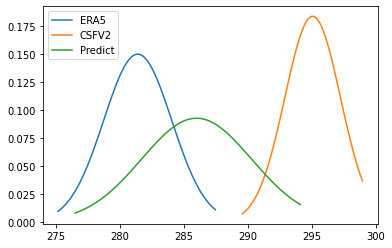

後90天
28 Minimum_90 ERA5: 284.94 CSFV2: 285.22 Predict: 280.07
28 Skewness_90 ERA5: 2.33 CSFV2: 4.4 Predict: 2.58
28 X_180 ERA5: 289.38 CSFV2: 293.34 Predict: 284.73
28 Y_180 ERA5: 280.48 CSFV2: 276.18 Predict: 275.34
28 Mean_180 ERA5: -0.11 CSFV2: -0.14 Predict: -0.13


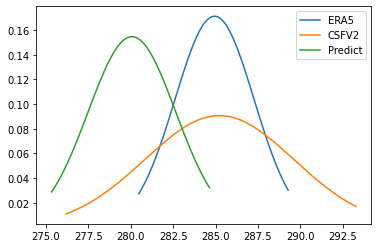

前90天
29 X_90 ERA5: 281.59 CSFV2: 292.24 Predict: 282.45
29 Y_90 ERA5: 2.84 CSFV2: 3.35 Predict: 3.44
29 Mean_90 ERA5: 288.19 CSFV2: 297.87 Predict: 290.01
29 STD_90 ERA5: 275.22 CSFV2: 284.53 Predict: 274.63
29 Maximum_90 ERA5: 0.06 CSFV2: -0.24 Predict: -0.06


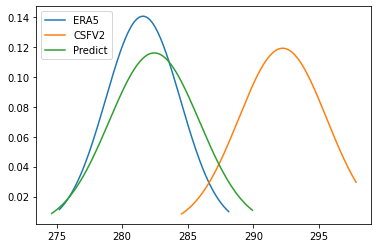

後90天
29 Minimum_90 ERA5: 283.2 CSFV2: 281.74 Predict: 281.16
29 Skewness_90 ERA5: 2.11 CSFV2: 2.94 Predict: 2.68
29 X_180 ERA5: 286.93 CSFV2: 288.75 Predict: 285.91
29 Y_180 ERA5: 278.65 CSFV2: 275.28 Predict: 276.33
29 Mean_180 ERA5: -0.34 CSFV2: 0.11 Predict: -0.17


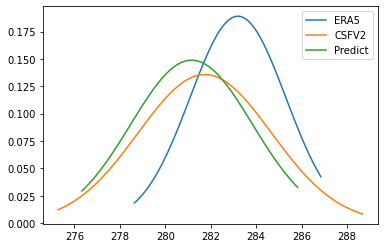

前90天
30 X_90 ERA5: 282.92 CSFV2: 290.26 Predict: 281.28
30 Y_90 ERA5: 3.63 CSFV2: 4.19 Predict: 2.86
30 Mean_90 ERA5: 290.81 CSFV2: 297.25 Predict: 288.2
30 STD_90 ERA5: 275.78 CSFV2: 280.27 Predict: 274.56
30 Maximum_90 ERA5: 0.13 CSFV2: -0.29 Predict: -0.02


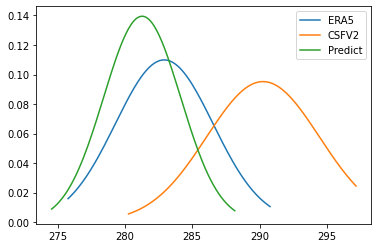

後90天
30 Minimum_90 ERA5: 281.41 CSFV2: 281.36 Predict: 283.51
30 Skewness_90 ERA5: 2.56 CSFV2: 2.63 Predict: 2.7
30 X_180 ERA5: 286.22 CSFV2: 287.36 Predict: 288.17
30 Y_180 ERA5: 276.34 CSFV2: 275.14 Predict: 278.63
30 Mean_180 ERA5: -0.14 CSFV2: -0.05 Predict: -0.22


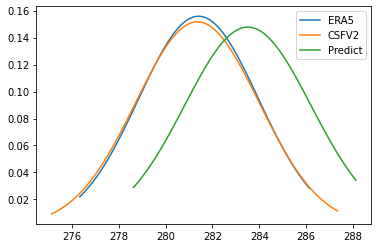

前90天
31 X_90 ERA5: 281.59 CSFV2: 289.84 Predict: 281.17
31 Y_90 ERA5: 2.78 CSFV2: 4.3 Predict: 2.83
31 Mean_90 ERA5: 287.68 CSFV2: 297.12 Predict: 288.06
31 STD_90 ERA5: 275.2 CSFV2: 279.93 Predict: 274.53
31 Maximum_90 ERA5: -0.08 CSFV2: -0.28 Predict: -0.01


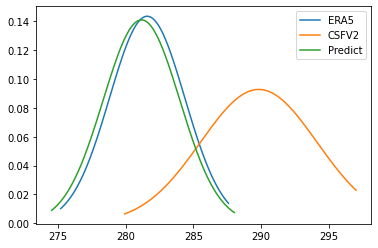

後90天
31 Minimum_90 ERA5: 286.49 CSFV2: 281.38 Predict: 283.88
31 Skewness_90 ERA5: 2.27 CSFV2: 2.66 Predict: 2.71
31 X_180 ERA5: 290.32 CSFV2: 287.46 Predict: 288.53
31 Y_180 ERA5: 281.72 CSFV2: 275.14 Predict: 279.0
31 Mean_180 ERA5: -0.32 CSFV2: -0.03 Predict: -0.22


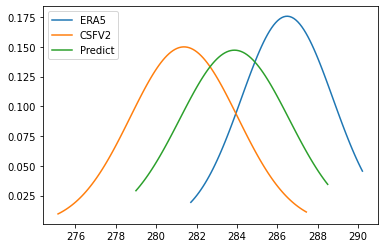

前90天
32 X_90 ERA5: 281.99 CSFV2: 294.46 Predict: 284.93
32 Y_90 ERA5: 3.03 CSFV2: 2.56 Predict: 4.21
32 Mean_90 ERA5: 288.84 CSFV2: 298.87 Predict: 293.16
32 STD_90 ERA5: 275.25 CSFV2: 287.86 Predict: 275.63
32 Maximum_90 ERA5: -0.06 CSFV2: -0.41 Predict: -0.15


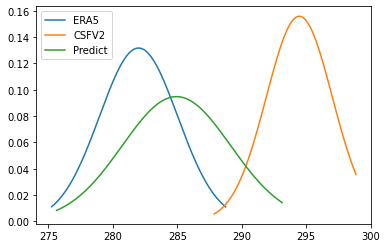

後90天
32 Minimum_90 ERA5: 287.76 CSFV2: 284.06 Predict: 279.91
32 Skewness_90 ERA5: 2.19 CSFV2: 4.06 Predict: 2.61
32 X_180 ERA5: 291.58 CSFV2: 291.88 Predict: 284.63
32 Y_180 ERA5: 283.13 CSFV2: 275.98 Predict: 275.16
32 Mean_180 ERA5: -0.22 CSFV2: -0.03 Predict: -0.13


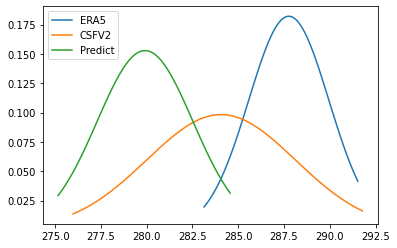

前90天
33 X_90 ERA5: 281.74 CSFV2: 288.84 Predict: 281.36
33 Y_90 ERA5: 2.94 CSFV2: 4.49 Predict: 2.79
33 Mean_90 ERA5: 288.75 CSFV2: 296.67 Predict: 288.15
33 STD_90 ERA5: 275.28 CSFV2: 278.72 Predict: 274.73
33 Maximum_90 ERA5: 0.11 CSFV2: -0.29 Predict: -0.02


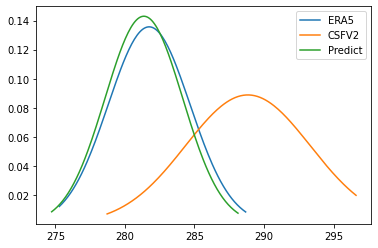

後90天
33 Minimum_90 ERA5: 282.91 CSFV2: 281.5 Predict: 284.71
33 Skewness_90 ERA5: 2.23 CSFV2: 2.73 Predict: 2.67
33 X_180 ERA5: 286.8 CSFV2: 287.49 Predict: 289.3
33 Y_180 ERA5: 278.05 CSFV2: 275.16 Predict: 279.83
33 Mean_180 ERA5: -0.38 CSFV2: -0.09 Predict: -0.23


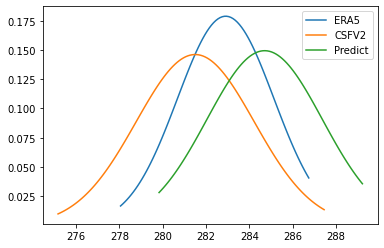

前90天
34 X_90 ERA5: 281.58 CSFV2: 290.12 Predict: 281.17
34 Y_90 ERA5: 2.77 CSFV2: 4.23 Predict: 2.85
34 Mean_90 ERA5: 287.62 CSFV2: 297.22 Predict: 288.08
34 STD_90 ERA5: 275.19 CSFV2: 280.1 Predict: 274.5
34 Maximum_90 ERA5: -0.09 CSFV2: -0.29 Predict: -0.01


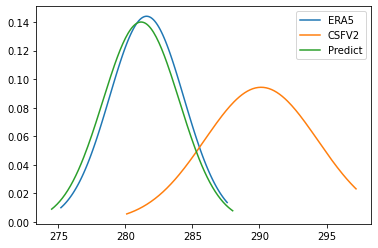

後90天
34 Minimum_90 ERA5: 286.35 CSFV2: 281.37 Predict: 283.82
34 Skewness_90 ERA5: 2.3 CSFV2: 2.64 Predict: 2.71
34 X_180 ERA5: 290.24 CSFV2: 287.4 Predict: 288.48
34 Y_180 ERA5: 281.54 CSFV2: 275.15 Predict: 278.94
34 Mean_180 ERA5: -0.3 CSFV2: -0.04 Predict: -0.22


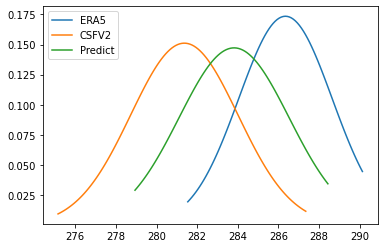

前90天
35 X_90 ERA5: 281.67 CSFV2: 293.96 Predict: 284.16
35 Y_90 ERA5: 2.81 CSFV2: 2.82 Predict: 4.1
35 Mean_90 ERA5: 287.72 CSFV2: 298.73 Predict: 292.37
35 STD_90 ERA5: 275.23 CSFV2: 286.91 Predict: 275.1
35 Maximum_90 ERA5: -0.09 CSFV2: -0.4 Predict: -0.12


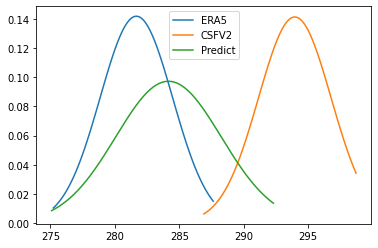

後90天
35 Minimum_90 ERA5: 286.98 CSFV2: 283.36 Predict: 279.88
35 Skewness_90 ERA5: 2.15 CSFV2: 3.8 Predict: 2.62
35 X_180 ERA5: 290.75 CSFV2: 291.17 Predict: 284.62
35 Y_180 ERA5: 282.24 CSFV2: 275.88 Predict: 275.13
35 Mean_180 ERA5: -0.35 CSFV2: 0.06 Predict: -0.13


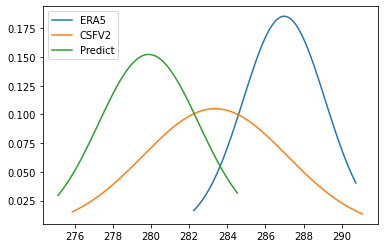

前90天
36 X_90 ERA5: 283.85 CSFV2: 294.77 Predict: 285.5
36 Y_90 ERA5: 4.0 CSFV2: 2.35 Predict: 4.32
36 Mean_90 ERA5: 291.7 CSFV2: 298.91 Predict: 293.76
36 STD_90 ERA5: 275.95 CSFV2: 288.8 Predict: 275.99
36 Maximum_90 ERA5: -0.01 CSFV2: -0.4 Predict: -0.17


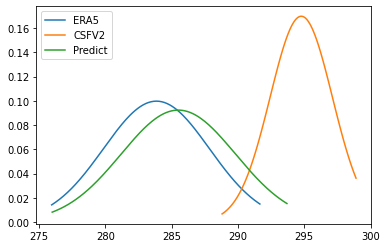

後90天
36 Minimum_90 ERA5: 280.86 CSFV2: 284.58 Predict: 279.91
36 Skewness_90 ERA5: 2.39 CSFV2: 4.2 Predict: 2.58
36 X_180 ERA5: 285.84 CSFV2: 292.69 Predict: 284.6
36 Y_180 ERA5: 276.29 CSFV2: 276.04 Predict: 275.19
36 Mean_180 ERA5: -0.04 CSFV2: -0.09 Predict: -0.12


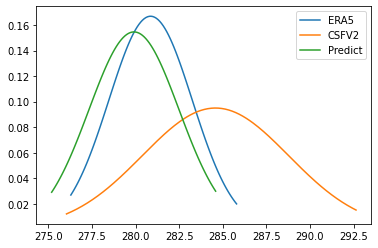

前90天
37 X_90 ERA5: 282.06 CSFV2: 293.8 Predict: 283.89
37 Y_90 ERA5: 3.06 CSFV2: 2.91 Predict: 4.0
37 Mean_90 ERA5: 288.93 CSFV2: 298.68 Predict: 292.0
37 STD_90 ERA5: 275.25 CSFV2: 286.54 Predict: 275.05
37 Maximum_90 ERA5: -0.06 CSFV2: -0.41 Predict: -0.11


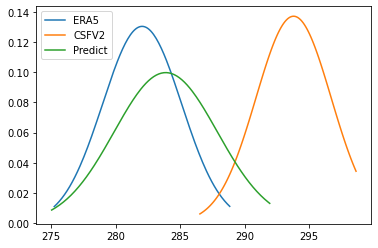

後90天
37 Minimum_90 ERA5: 287.84 CSFV2: 283.18 Predict: 280.09
37 Skewness_90 ERA5: 2.2 CSFV2: 3.73 Predict: 2.64
37 X_180 ERA5: 291.64 CSFV2: 290.99 Predict: 284.84
37 Y_180 ERA5: 283.19 CSFV2: 275.84 Predict: 275.32
37 Mean_180 ERA5: -0.22 CSFV2: 0.09 Predict: -0.13


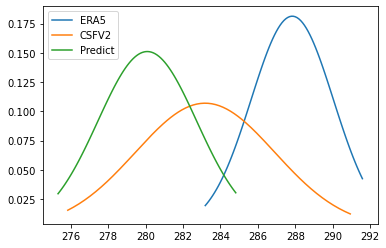

前90天
38 X_90 ERA5: 281.38 CSFV2: 286.5 Predict: 281.74
38 Y_90 ERA5: 2.66 CSFV2: 4.49 Predict: 2.99
38 Mean_90 ERA5: 287.46 CSFV2: 295.05 Predict: 288.66
38 STD_90 ERA5: 275.14 CSFV2: 277.47 Predict: 274.78
38 Maximum_90 ERA5: -0.03 CSFV2: -0.14 Predict: -0.04


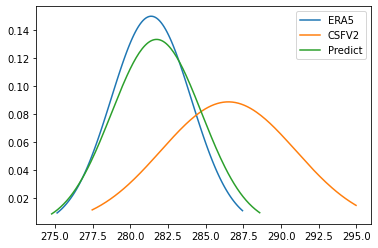

後90天
38 Minimum_90 ERA5: 285.03 CSFV2: 282.13 Predict: 286.65
38 Skewness_90 ERA5: 2.34 CSFV2: 3.09 Predict: 2.56
38 X_180 ERA5: 289.46 CSFV2: 288.99 Predict: 291.05
38 Y_180 ERA5: 280.51 CSFV2: 275.26 Predict: 281.86
38 Mean_180 ERA5: -0.12 CSFV2: -0.07 Predict: -0.25


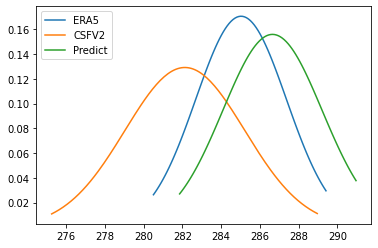

前90天
39 X_90 ERA5: 281.37 CSFV2: 288.69 Predict: 281.41
39 Y_90 ERA5: 2.66 CSFV2: 4.51 Predict: 2.8
39 Mean_90 ERA5: 287.78 CSFV2: 296.6 Predict: 288.21
39 STD_90 ERA5: 275.14 CSFV2: 278.55 Predict: 274.78
39 Maximum_90 ERA5: -0.01 CSFV2: -0.3 Predict: -0.02


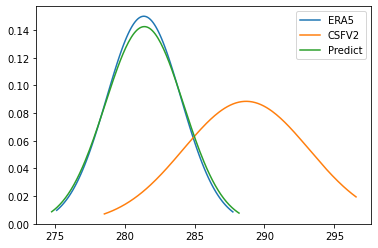

後90天
39 Minimum_90 ERA5: 284.5 CSFV2: 281.52 Predict: 284.88
39 Skewness_90 ERA5: 2.17 CSFV2: 2.73 Predict: 2.67
39 X_180 ERA5: 288.7 CSFV2: 287.49 Predict: 289.46
39 Y_180 ERA5: 280.21 CSFV2: 275.17 Predict: 280.01
39 Mean_180 ERA5: -0.09 CSFV2: -0.09 Predict: -0.23


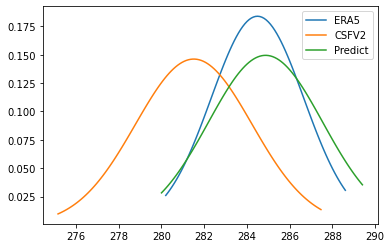

前90天
40 X_90 ERA5: 281.43 CSFV2: 289.41 Predict: 281.22
40 Y_90 ERA5: 2.73 CSFV2: 4.4 Predict: 2.78
40 Mean_90 ERA5: 287.96 CSFV2: 296.94 Predict: 288.03
40 STD_90 ERA5: 275.1 CSFV2: 279.45 Predict: 274.63
40 Maximum_90 ERA5: 0.02 CSFV2: -0.28 Predict: -0.02


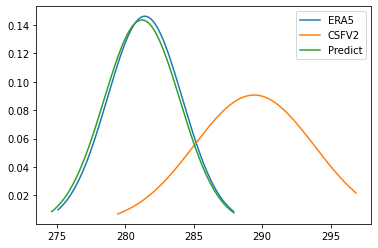

後90天
40 Minimum_90 ERA5: 283.91 CSFV2: 281.42 Predict: 284.34
40 Skewness_90 ERA5: 2.12 CSFV2: 2.71 Predict: 2.69
40 X_180 ERA5: 288.23 CSFV2: 287.54 Predict: 288.96
40 Y_180 ERA5: 279.67 CSFV2: 275.14 Predict: 279.46
40 Mean_180 ERA5: -0.11 CSFV2: -0.04 Predict: -0.23


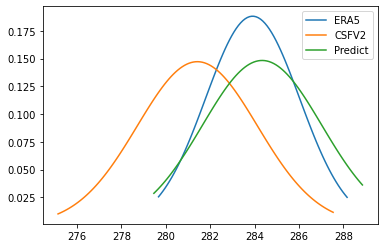

前90天
41 X_90 ERA5: 283.95 CSFV2: 288.98 Predict: 281.18
41 Y_90 ERA5: 4.03 CSFV2: 4.47 Predict: 2.76
41 Mean_90 ERA5: 291.79 CSFV2: 296.76 Predict: 287.95
41 STD_90 ERA5: 275.96 CSFV2: 278.91 Predict: 274.64
41 Maximum_90 ERA5: -0.02 CSFV2: -0.28 Predict: -0.01


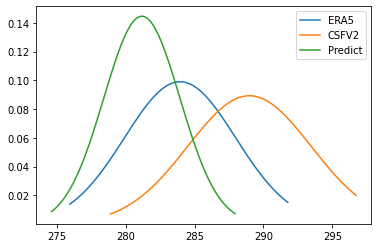

後90天
41 Minimum_90 ERA5: 280.79 CSFV2: 281.48 Predict: 284.78
41 Skewness_90 ERA5: 2.34 CSFV2: 2.72 Predict: 2.68
41 X_180 ERA5: 285.64 CSFV2: 287.48 Predict: 289.37
41 Y_180 ERA5: 276.27 CSFV2: 275.16 Predict: 279.9
41 Mean_180 ERA5: -0.06 CSFV2: -0.08 Predict: -0.23


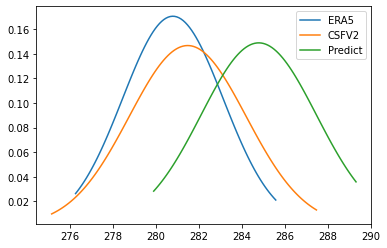

前90天
42 X_90 ERA5: 282.2 CSFV2: 292.75 Predict: 283.23
42 Y_90 ERA5: 3.12 CSFV2: 3.2 Predict: 3.63
42 Mean_90 ERA5: 289.05 CSFV2: 298.16 Predict: 290.94
42 STD_90 ERA5: 275.27 CSFV2: 285.44 Predict: 275.04
42 Maximum_90 ERA5: -0.08 CSFV2: -0.26 Predict: -0.09


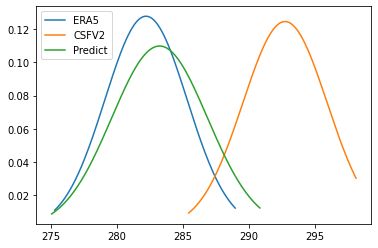

後90天
42 Minimum_90 ERA5: 287.94 CSFV2: 282.13 Predict: 280.69
42 Skewness_90 ERA5: 2.23 CSFV2: 3.15 Predict: 2.67
42 X_180 ERA5: 291.82 CSFV2: 289.4 Predict: 285.45
42 Y_180 ERA5: 283.24 CSFV2: 275.53 Predict: 275.88
42 Mean_180 ERA5: -0.21 CSFV2: 0.12 Predict: -0.16


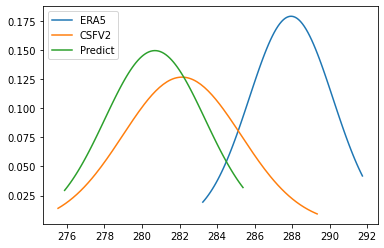

前90天
43 X_90 ERA5: 281.36 CSFV2: 288.02 Predict: 281.35
43 Y_90 ERA5: 2.63 CSFV2: 4.54 Predict: 2.8
43 Mean_90 ERA5: 287.36 CSFV2: 296.05 Predict: 288.11
43 STD_90 ERA5: 275.14 CSFV2: 278.16 Predict: 274.75
43 Maximum_90 ERA5: -0.05 CSFV2: -0.3 Predict: -0.02


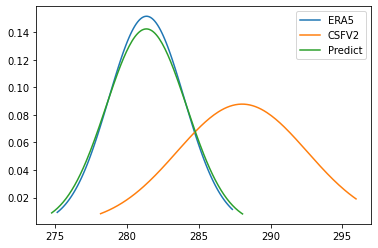

後90天
43 Minimum_90 ERA5: 284.76 CSFV2: 281.61 Predict: 285.58
43 Skewness_90 ERA5: 2.24 CSFV2: 2.79 Predict: 2.64
43 X_180 ERA5: 289.0 CSFV2: 287.71 Predict: 290.1
43 Y_180 ERA5: 280.41 CSFV2: 275.21 Predict: 280.73
43 Mean_180 ERA5: -0.1 CSFV2: -0.08 Predict: -0.24


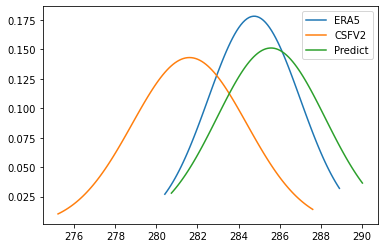

前90天
44 X_90 ERA5: 282.22 CSFV2: 290.78 Predict: 281.63
44 Y_90 ERA5: 3.2 CSFV2: 4.04 Predict: 2.93
44 Mean_90 ERA5: 289.55 CSFV2: 297.42 Predict: 288.61
44 STD_90 ERA5: 275.54 CSFV2: 280.63 Predict: 274.74
44 Maximum_90 ERA5: 0.12 CSFV2: -0.29 Predict: -0.03


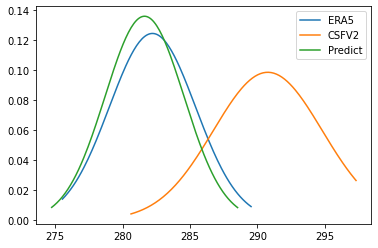

後90天
44 Minimum_90 ERA5: 282.16 CSFV2: 281.4 Predict: 282.92
44 Skewness_90 ERA5: 2.53 CSFV2: 2.71 Predict: 2.71
44 X_180 ERA5: 286.56 CSFV2: 287.91 Predict: 287.61
44 Y_180 ERA5: 276.83 CSFV2: 275.11 Predict: 278.04
44 Mean_180 ERA5: -0.29 CSFV2: 0.01 Predict: -0.21


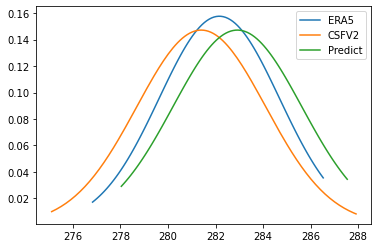

前90天
45 X_90 ERA5: 282.4 CSFV2: 288.41 Predict: 281.47
45 Y_90 ERA5: 3.31 CSFV2: 4.54 Predict: 2.77
45 Mean_90 ERA5: 289.98 CSFV2: 296.39 Predict: 288.19
45 STD_90 ERA5: 275.62 CSFV2: 278.31 Predict: 274.9
45 Maximum_90 ERA5: 0.15 CSFV2: -0.31 Predict: -0.03


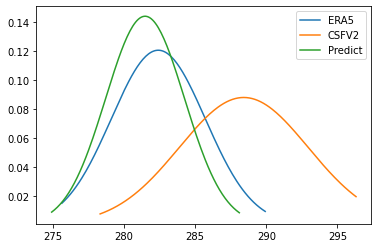

後90天
45 Minimum_90 ERA5: 281.92 CSFV2: 281.56 Predict: 285.27
45 Skewness_90 ERA5: 2.62 CSFV2: 2.76 Predict: 2.65
45 X_180 ERA5: 286.57 CSFV2: 287.51 Predict: 289.81
45 Y_180 ERA5: 276.57 CSFV2: 275.18 Predict: 280.41
45 Mean_180 ERA5: -0.23 CSFV2: -0.1 Predict: -0.24


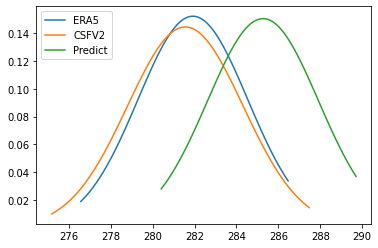

前90天
46 X_90 ERA5: 281.55 CSFV2: 287.67 Predict: 281.36
46 Y_90 ERA5: 2.82 CSFV2: 4.53 Predict: 2.83
46 Mean_90 ERA5: 288.19 CSFV2: 295.79 Predict: 288.13
46 STD_90 ERA5: 275.21 CSFV2: 278.12 Predict: 274.74
46 Maximum_90 ERA5: 0.06 CSFV2: -0.24 Predict: -0.03


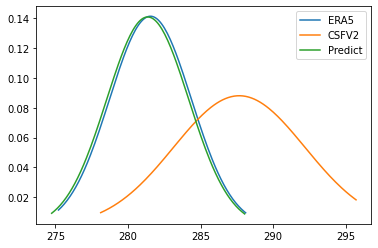

後90天
46 Minimum_90 ERA5: 283.28 CSFV2: 281.67 Predict: 285.88
46 Skewness_90 ERA5: 2.09 CSFV2: 2.81 Predict: 2.62
46 X_180 ERA5: 287.01 CSFV2: 287.72 Predict: 290.37
46 Y_180 ERA5: 278.8 CSFV2: 275.23 Predict: 281.05
46 Mean_180 ERA5: -0.31 CSFV2: -0.09 Predict: -0.24


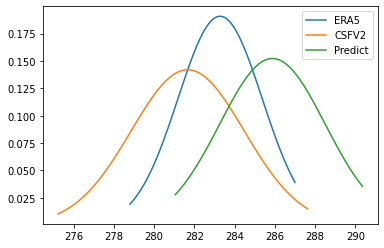

前90天
47 X_90 ERA5: 281.46 CSFV2: 294.32 Predict: 284.6
47 Y_90 ERA5: 2.72 CSFV2: 2.64 Predict: 4.21
47 Mean_90 ERA5: 287.52 CSFV2: 298.83 Predict: 292.87
47 STD_90 ERA5: 275.14 CSFV2: 287.5 Predict: 275.32
47 Maximum_90 ERA5: -0.07 CSFV2: -0.43 Predict: -0.14


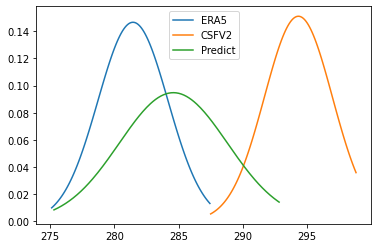

後90天
47 Minimum_90 ERA5: 285.56 CSFV2: 283.85 Predict: 279.78
47 Skewness_90 ERA5: 2.36 CSFV2: 4.0 Predict: 2.6
47 X_180 ERA5: 289.74 CSFV2: 291.7 Predict: 284.5
47 Y_180 ERA5: 280.86 CSFV2: 275.95 Predict: 275.04
47 Mean_180 ERA5: -0.19 CSFV2: -0.01 Predict: -0.12


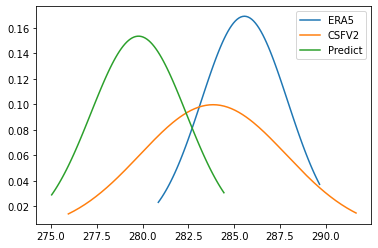

前90天
48 X_90 ERA5: 281.81 CSFV2: 287.05 Predict: 281.39
48 Y_90 ERA5: 2.98 CSFV2: 4.51 Predict: 2.95
48 Mean_90 ERA5: 288.94 CSFV2: 295.5 Predict: 288.29
48 STD_90 ERA5: 275.35 CSFV2: 277.83 Predict: 274.55
48 Maximum_90 ERA5: 0.12 CSFV2: -0.18 Predict: -0.03


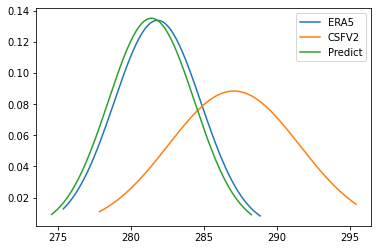

後90天
48 Minimum_90 ERA5: 282.8 CSFV2: 281.87 Predict: 286.22
48 Skewness_90 ERA5: 2.26 CSFV2: 2.96 Predict: 2.59
48 X_180 ERA5: 286.67 CSFV2: 288.62 Predict: 290.67
48 Y_180 ERA5: 277.91 CSFV2: 275.24 Predict: 281.41
48 Mean_180 ERA5: -0.39 CSFV2: -0.06 Predict: -0.24


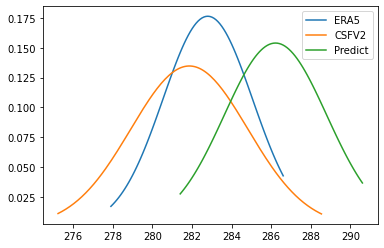

前90天
49 X_90 ERA5: 282.35 CSFV2: 285.63 Predict: 282.25
49 Y_90 ERA5: 3.18 CSFV2: 4.44 Predict: 3.23
49 Mean_90 ERA5: 289.43 CSFV2: 294.19 Predict: 289.36
49 STD_90 ERA5: 275.29 CSFV2: 276.66 Predict: 274.85
49 Maximum_90 ERA5: -0.08 CSFV2: -0.12 Predict: -0.08


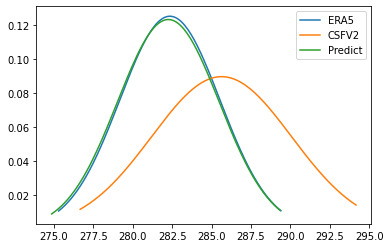

後90天
49 Minimum_90 ERA5: 288.11 CSFV2: 282.57 Predict: 287.97
49 Skewness_90 ERA5: 2.2 CSFV2: 3.19 Predict: 2.44
49 X_180 ERA5: 292.14 CSFV2: 289.69 Predict: 292.19
49 Y_180 ERA5: 283.56 CSFV2: 275.57 Predict: 283.32
49 Mean_180 ERA5: -0.15 CSFV2: -0.07 Predict: -0.24


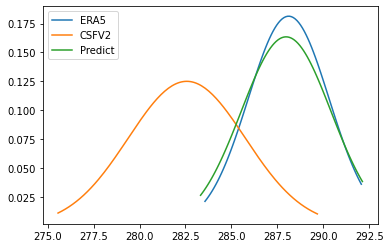

前90天
50 X_90 ERA5: 281.72 CSFV2: 286.78 Predict: 281.68
50 Y_90 ERA5: 2.86 CSFV2: 4.51 Predict: 2.99
50 Mean_90 ERA5: 287.93 CSFV2: 295.35 Predict: 288.61
50 STD_90 ERA5: 275.24 CSFV2: 277.65 Predict: 274.72
50 Maximum_90 ERA5: -0.07 CSFV2: -0.16 Predict: -0.04


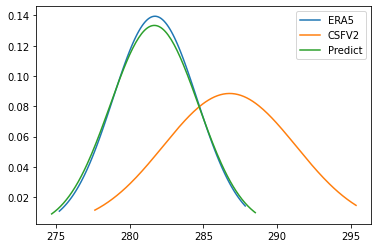

後90天
50 Minimum_90 ERA5: 287.24 CSFV2: 281.99 Predict: 286.42
50 Skewness_90 ERA5: 2.15 CSFV2: 3.03 Predict: 2.57
50 X_180 ERA5: 291.06 CSFV2: 288.84 Predict: 290.85
50 Y_180 ERA5: 282.52 CSFV2: 275.25 Predict: 281.62
50 Mean_180 ERA5: -0.3 CSFV2: -0.06 Predict: -0.24


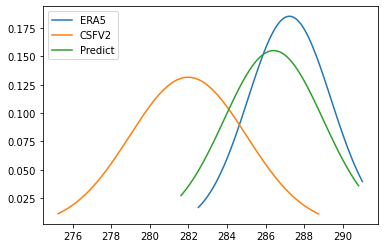

前90天
51 X_90 ERA5: 282.13 CSFV2: 292.14 Predict: 282.29
51 Y_90 ERA5: 3.09 CSFV2: 3.39 Predict: 3.38
51 Mean_90 ERA5: 288.99 CSFV2: 297.83 Predict: 289.8
51 STD_90 ERA5: 275.26 CSFV2: 284.26 Predict: 274.59
51 Maximum_90 ERA5: -0.07 CSFV2: -0.25 Predict: -0.06


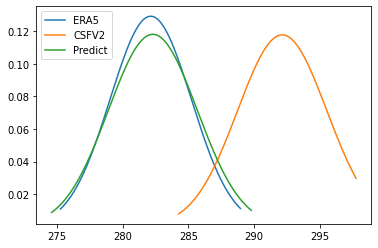

後90天
51 Minimum_90 ERA5: 287.89 CSFV2: 281.68 Predict: 281.27
51 Skewness_90 ERA5: 2.21 CSFV2: 2.9 Predict: 2.68
51 X_180 ERA5: 291.73 CSFV2: 288.53 Predict: 286.02
51 Y_180 ERA5: 283.22 CSFV2: 275.26 Predict: 276.44
51 Mean_180 ERA5: -0.21 CSFV2: 0.09 Predict: -0.17


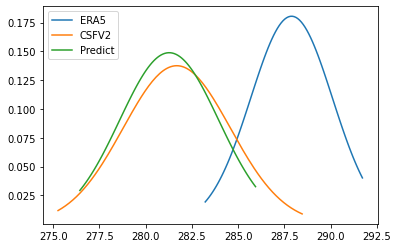

前90天
52 X_90 ERA5: 281.41 CSFV2: 294.97 Predict: 285.87
52 Y_90 ERA5: 2.69 CSFV2: 2.25 Predict: 4.32
52 Mean_90 ERA5: 287.53 CSFV2: 298.96 Predict: 294.05
52 STD_90 ERA5: 275.14 CSFV2: 289.05 Predict: 276.35
52 Maximum_90 ERA5: -0.04 CSFV2: -0.41 Predict: -0.18


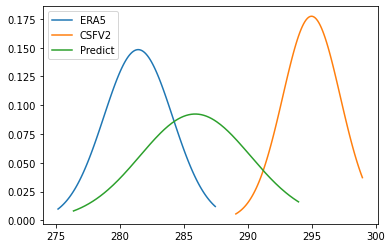

後90天
52 Minimum_90 ERA5: 285.21 CSFV2: 285.01 Predict: 279.98
52 Skewness_90 ERA5: 2.34 CSFV2: 4.35 Predict: 2.58
52 X_180 ERA5: 289.59 CSFV2: 293.09 Predict: 284.65
52 Y_180 ERA5: 280.61 CSFV2: 276.15 Predict: 275.25
52 Mean_180 ERA5: -0.14 CSFV2: -0.12 Predict: -0.13


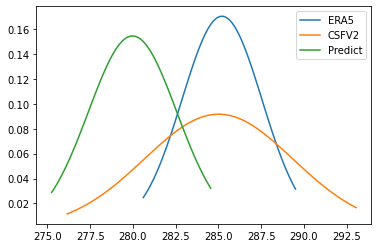

前90天
53 X_90 ERA5: 283.27 CSFV2: 288.28 Predict: 281.42
53 Y_90 ERA5: 3.76 CSFV2: 4.55 Predict: 2.83
53 Mean_90 ERA5: 291.08 CSFV2: 296.27 Predict: 288.24
53 STD_90 ERA5: 275.86 CSFV2: 278.21 Predict: 274.73
53 Maximum_90 ERA5: 0.08 CSFV2: -0.32 Predict: -0.03


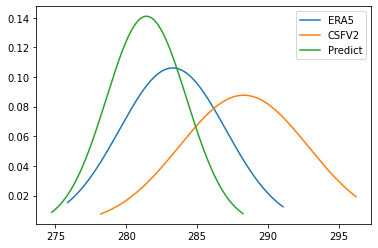

後90天
53 Minimum_90 ERA5: 281.12 CSFV2: 281.58 Predict: 285.25
53 Skewness_90 ERA5: 2.52 CSFV2: 2.77 Predict: 2.64
53 X_180 ERA5: 286.11 CSFV2: 287.62 Predict: 289.8
53 Y_180 ERA5: 276.3 CSFV2: 275.19 Predict: 280.4
53 Mean_180 ERA5: -0.07 CSFV2: -0.09 Predict: -0.24


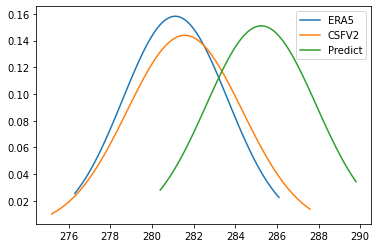

前90天
54 X_90 ERA5: 285.11 CSFV2: 293.63 Predict: 283.8
54 Y_90 ERA5: 4.38 CSFV2: 3.0 Predict: 3.92
54 Mean_90 ERA5: 293.19 CSFV2: 298.63 Predict: 291.8
54 STD_90 ERA5: 276.16 CSFV2: 286.2 Predict: 275.09
54 Maximum_90 ERA5: -0.13 CSFV2: -0.39 Predict: -0.11


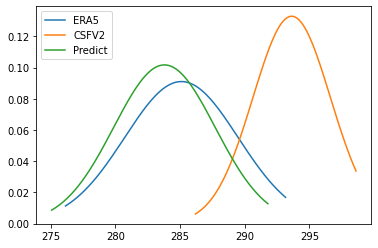

後90天
54 Minimum_90 ERA5: 280.92 CSFV2: 283.0 Predict: 280.15
54 Skewness_90 ERA5: 2.06 CSFV2: 3.66 Predict: 2.65
54 X_180 ERA5: 284.73 CSFV2: 290.86 Predict: 284.9
54 Y_180 ERA5: 276.89 CSFV2: 275.81 Predict: 275.37
54 Mean_180 ERA5: -0.18 CSFV2: 0.12 Predict: -0.14


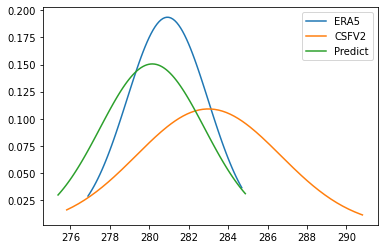

前90天
55 X_90 ERA5: 282.13 CSFV2: 293.88 Predict: 284.02
55 Y_90 ERA5: 3.15 CSFV2: 2.86 Predict: 4.06
55 Mean_90 ERA5: 289.4 CSFV2: 298.71 Predict: 292.19
55 STD_90 ERA5: 275.53 CSFV2: 286.72 Predict: 275.07
55 Maximum_90 ERA5: 0.12 CSFV2: -0.41 Predict: -0.12


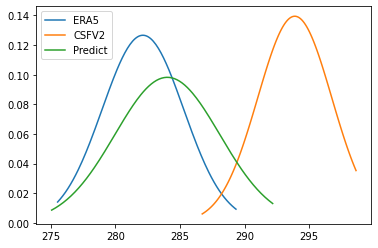

後90天
55 Minimum_90 ERA5: 282.28 CSFV2: 283.27 Predict: 279.98
55 Skewness_90 ERA5: 2.49 CSFV2: 3.76 Predict: 2.63
55 X_180 ERA5: 286.58 CSFV2: 291.08 Predict: 284.72
55 Y_180 ERA5: 276.96 CSFV2: 275.86 Predict: 275.23
55 Mean_180 ERA5: -0.32 CSFV2: 0.08 Predict: -0.13


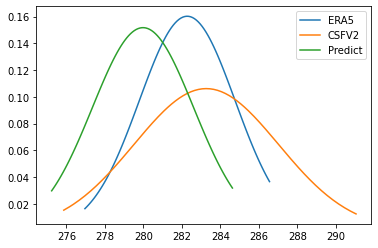

前90天
56 X_90 ERA5: 282.73 CSFV2: 294.54 Predict: 285.02
56 Y_90 ERA5: 3.19 CSFV2: 2.51 Predict: 4.23
56 Mean_90 ERA5: 289.74 CSFV2: 298.88 Predict: 293.26
56 STD_90 ERA5: 275.89 CSFV2: 288.07 Predict: 275.69
56 Maximum_90 ERA5: -0.08 CSFV2: -0.39 Predict: -0.15


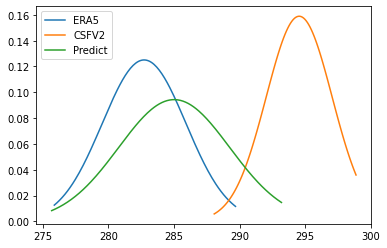

後90天
56 Minimum_90 ERA5: 288.77 CSFV2: 284.16 Predict: 279.91
56 Skewness_90 ERA5: 2.12 CSFV2: 4.07 Predict: 2.6
56 X_180 ERA5: 292.83 CSFV2: 292.0 Predict: 284.63
56 Y_180 ERA5: 284.67 CSFV2: 275.99 Predict: 275.16
56 Mean_180 ERA5: -0.09 CSFV2: -0.05 Predict: -0.13


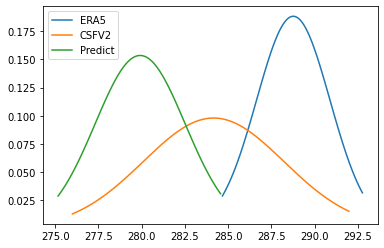

前90天
57 X_90 ERA5: 281.39 CSFV2: 293.55 Predict: 283.87
57 Y_90 ERA5: 2.69 CSFV2: 3.05 Predict: 3.93
57 Mean_90 ERA5: 287.88 CSFV2: 298.61 Predict: 291.9
57 STD_90 ERA5: 275.14 CSFV2: 286.1 Predict: 275.15
57 Maximum_90 ERA5: 0.01 CSFV2: -0.39 Predict: -0.11


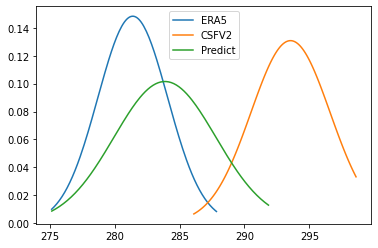

後90天
57 Minimum_90 ERA5: 284.35 CSFV2: 282.92 Predict: 280.21
57 Skewness_90 ERA5: 2.14 CSFV2: 3.63 Predict: 2.65
57 X_180 ERA5: 288.58 CSFV2: 290.81 Predict: 284.96
57 Y_180 ERA5: 280.1 CSFV2: 275.78 Predict: 275.43
57 Mean_180 ERA5: -0.08 CSFV2: 0.13 Predict: -0.14


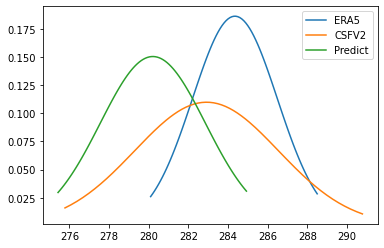

前90天
58 X_90 ERA5: 283.18 CSFV2: 289.13 Predict: 281.15
58 Y_90 ERA5: 3.73 CSFV2: 4.45 Predict: 2.78
58 Mean_90 ERA5: 290.99 CSFV2: 296.81 Predict: 287.94
58 STD_90 ERA5: 275.84 CSFV2: 279.13 Predict: 274.58
58 Maximum_90 ERA5: 0.09 CSFV2: -0.27 Predict: -0.02


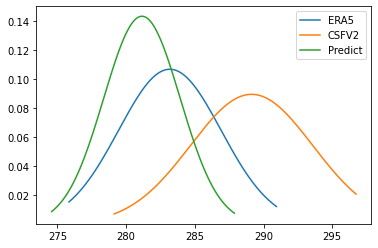

後90天
58 Minimum_90 ERA5: 281.19 CSFV2: 281.46 Predict: 284.54
58 Skewness_90 ERA5: 2.52 CSFV2: 2.72 Predict: 2.68
58 X_180 ERA5: 286.13 CSFV2: 287.52 Predict: 289.14
58 Y_180 ERA5: 276.31 CSFV2: 275.14 Predict: 279.66
58 Mean_180 ERA5: -0.09 CSFV2: -0.07 Predict: -0.23


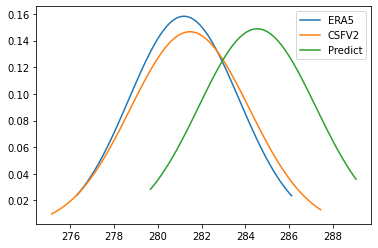

前90天
59 X_90 ERA5: 281.52 CSFV2: 287.79 Predict: 281.36
59 Y_90 ERA5: 2.73 CSFV2: 4.54 Predict: 2.85
59 Mean_90 ERA5: 287.49 CSFV2: 295.83 Predict: 288.17
59 STD_90 ERA5: 275.17 CSFV2: 278.14 Predict: 274.69
59 Maximum_90 ERA5: -0.09 CSFV2: -0.26 Predict: -0.03


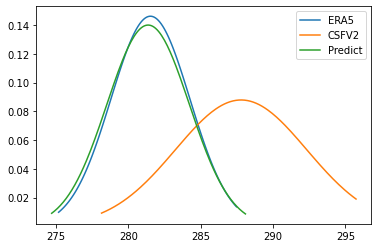

後90天
59 Minimum_90 ERA5: 285.96 CSFV2: 281.65 Predict: 285.84
59 Skewness_90 ERA5: 2.36 CSFV2: 2.8 Predict: 2.62
59 X_180 ERA5: 290.03 CSFV2: 287.67 Predict: 290.34
59 Y_180 ERA5: 281.1 CSFV2: 275.22 Predict: 281.01
59 Mean_180 ERA5: -0.25 CSFV2: -0.09 Predict: -0.24


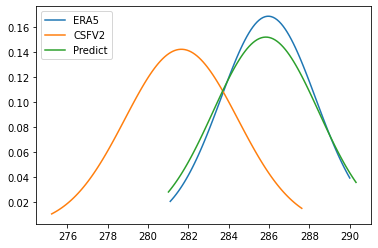

前90天
60 X_90 ERA5: 283.0 CSFV2: 291.04 Predict: 281.49
60 Y_90 ERA5: 3.66 CSFV2: 3.91 Predict: 3.01
60 Mean_90 ERA5: 290.86 CSFV2: 297.44 Predict: 288.58
60 STD_90 ERA5: 275.81 CSFV2: 281.07 Predict: 274.5
60 Maximum_90 ERA5: 0.12 CSFV2: -0.3 Predict: -0.03


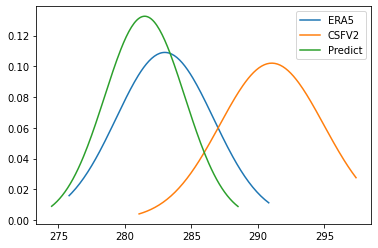

後90天
60 Minimum_90 ERA5: 281.33 CSFV2: 281.43 Predict: 282.75
60 Skewness_90 ERA5: 2.54 CSFV2: 2.73 Predict: 2.71
60 X_180 ERA5: 286.18 CSFV2: 287.96 Predict: 287.45
60 Y_180 ERA5: 276.32 CSFV2: 275.1 Predict: 277.88
60 Mean_180 ERA5: -0.12 CSFV2: 0.02 Predict: -0.2


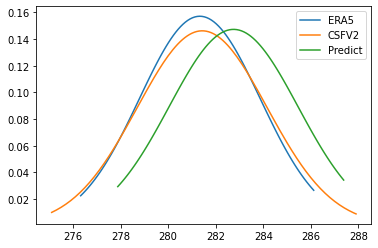

前90天
61 X_90 ERA5: 283.46 CSFV2: 289.7 Predict: 281.29
61 Y_90 ERA5: 3.84 CSFV2: 4.34 Predict: 2.79
61 Mean_90 ERA5: 291.31 CSFV2: 297.07 Predict: 288.11
61 STD_90 ERA5: 275.91 CSFV2: 279.76 Predict: 274.68
61 Maximum_90 ERA5: 0.05 CSFV2: -0.27 Predict: -0.02


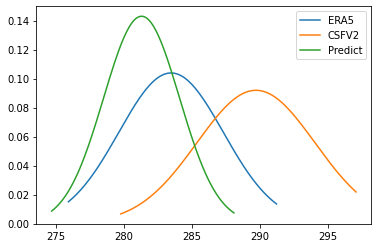

後90天
61 Minimum_90 ERA5: 281.03 CSFV2: 281.4 Predict: 284.15
61 Skewness_90 ERA5: 2.48 CSFV2: 2.68 Predict: 2.7
61 X_180 ERA5: 286.08 CSFV2: 287.5 Predict: 288.78
61 Y_180 ERA5: 276.28 CSFV2: 275.14 Predict: 279.26
61 Mean_180 ERA5: -0.03 CSFV2: -0.04 Predict: -0.23


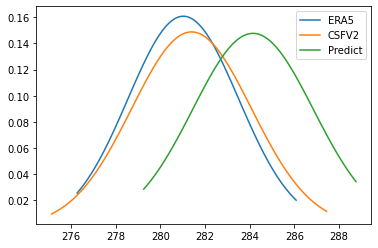

前90天
62 X_90 ERA5: 281.89 CSFV2: 291.55 Predict: 281.73
62 Y_90 ERA5: 3.02 CSFV2: 3.65 Predict: 3.13
62 Mean_90 ERA5: 289.06 CSFV2: 297.57 Predict: 288.97
62 STD_90 ERA5: 275.43 CSFV2: 282.51 Predict: 274.52
62 Maximum_90 ERA5: 0.13 CSFV2: -0.27 Predict: -0.03


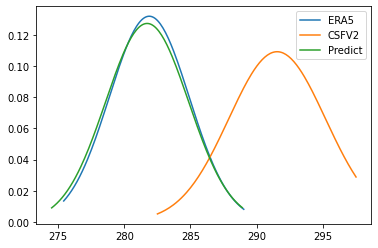

後90天
62 Minimum_90 ERA5: 282.68 CSFV2: 281.51 Predict: 282.22
62 Skewness_90 ERA5: 2.31 CSFV2: 2.81 Predict: 2.71
62 X_180 ERA5: 286.63 CSFV2: 288.23 Predict: 286.95
62 Y_180 ERA5: 277.6 CSFV2: 275.15 Predict: 277.36
62 Mean_180 ERA5: -0.4 CSFV2: 0.06 Predict: -0.19


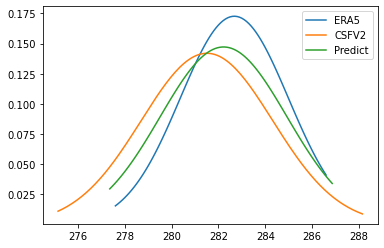

前90天
63 X_90 ERA5: 281.7 CSFV2: 286.21 Predict: 281.74
63 Y_90 ERA5: 2.83 CSFV2: 4.47 Predict: 3.14
63 Mean_90 ERA5: 287.81 CSFV2: 294.82 Predict: 288.83
63 STD_90 ERA5: 275.23 CSFV2: 277.34 Predict: 274.55
63 Maximum_90 ERA5: -0.08 CSFV2: -0.12 Predict: -0.05


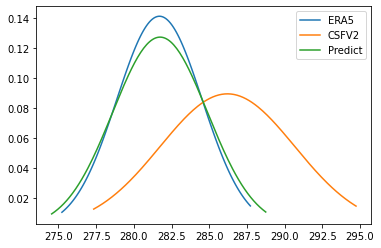

後90天
63 Minimum_90 ERA5: 287.11 CSFV2: 282.28 Predict: 287.1
63 Skewness_90 ERA5: 2.14 CSFV2: 3.16 Predict: 2.52
63 X_180 ERA5: 290.91 CSFV2: 289.22 Predict: 291.46
63 Y_180 ERA5: 282.39 CSFV2: 275.28 Predict: 282.34
63 Mean_180 ERA5: -0.32 CSFV2: -0.08 Predict: -0.24


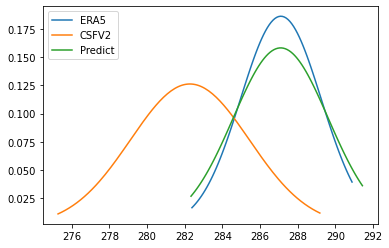

前90天
64 X_90 ERA5: 284.26 CSFV2: 290.91 Predict: 281.45
64 Y_90 ERA5: 4.09 CSFV2: 3.98 Predict: 2.94
64 Mean_90 ERA5: 292.16 CSFV2: 297.43 Predict: 288.45
64 STD_90 ERA5: 276.01 CSFV2: 280.84 Predict: 274.57
64 Maximum_90 ERA5: -0.06 CSFV2: -0.3 Predict: -0.02


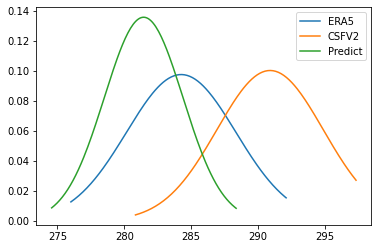

後90天
64 Minimum_90 ERA5: 280.6 CSFV2: 281.41 Predict: 282.98
64 Skewness_90 ERA5: 2.15 CSFV2: 2.72 Predict: 2.71
64 X_180 ERA5: 284.68 CSFV2: 287.95 Predict: 287.67
64 Y_180 ERA5: 276.23 CSFV2: 275.09 Predict: 278.11
64 Mean_180 ERA5: -0.2 CSFV2: 0.01 Predict: -0.21


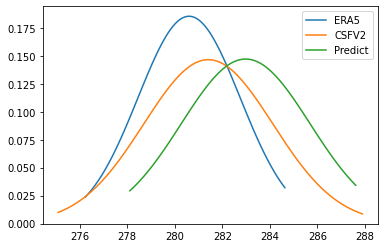

前90天
65 X_90 ERA5: 282.58 CSFV2: 291.67 Predict: 281.71
65 Y_90 ERA5: 3.44 CSFV2: 3.58 Predict: 3.2
65 Mean_90 ERA5: 290.45 CSFV2: 297.61 Predict: 289.04
65 STD_90 ERA5: 275.64 CSFV2: 282.88 Predict: 274.39
65 Maximum_90 ERA5: 0.16 CSFV2: -0.26 Predict: -0.03


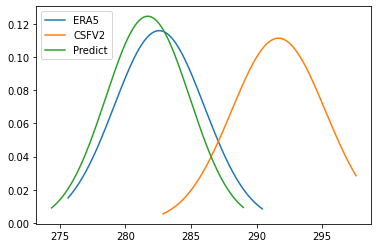

後90天
65 Minimum_90 ERA5: 281.75 CSFV2: 281.52 Predict: 281.93
65 Skewness_90 ERA5: 2.61 CSFV2: 2.82 Predict: 2.7
65 X_180 ERA5: 286.52 CSFV2: 288.25 Predict: 286.66
65 Y_180 ERA5: 276.5 CSFV2: 275.2 Predict: 277.08
65 Mean_180 ERA5: -0.19 CSFV2: 0.07 Predict: -0.19


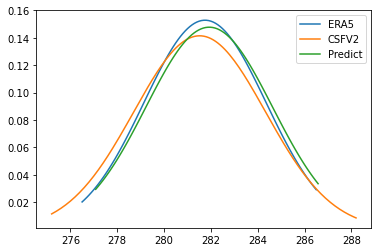

前90天
66 X_90 ERA5: 281.4 CSFV2: 287.55 Predict: 281.18
66 Y_90 ERA5: 2.68 CSFV2: 4.52 Predict: 2.9
66 Mean_90 ERA5: 287.5 CSFV2: 295.74 Predict: 288.06
66 STD_90 ERA5: 275.14 CSFV2: 278.1 Predict: 274.46
66 Maximum_90 ERA5: -0.04 CSFV2: -0.22 Predict: -0.02


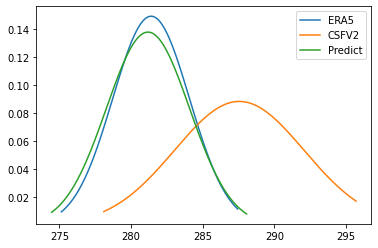

後90天
66 Minimum_90 ERA5: 285.11 CSFV2: 281.7 Predict: 285.79
66 Skewness_90 ERA5: 2.34 CSFV2: 2.83 Predict: 2.62
66 X_180 ERA5: 289.56 CSFV2: 287.81 Predict: 290.29
66 Y_180 ERA5: 280.55 CSFV2: 275.23 Predict: 280.96
66 Mean_180 ERA5: -0.12 CSFV2: -0.08 Predict: -0.24


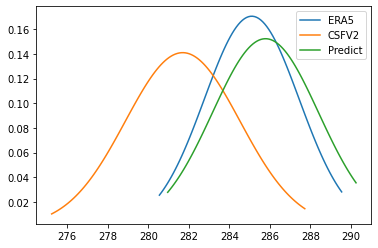

前90天
67 X_90 ERA5: 281.93 CSFV2: 292.84 Predict: 283.04
67 Y_90 ERA5: 3.0 CSFV2: 3.18 Predict: 3.63
67 Mean_90 ERA5: 288.77 CSFV2: 298.22 Predict: 290.78
67 STD_90 ERA5: 275.25 CSFV2: 285.54 Predict: 274.86
67 Maximum_90 ERA5: -0.06 CSFV2: -0.27 Predict: -0.08


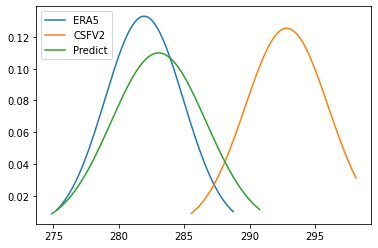

後90天
67 Minimum_90 ERA5: 287.67 CSFV2: 282.22 Predict: 280.57
67 Skewness_90 ERA5: 2.18 CSFV2: 3.2 Predict: 2.67
67 X_180 ERA5: 291.51 CSFV2: 289.55 Predict: 285.33
67 Y_180 ERA5: 283.08 CSFV2: 275.54 Predict: 275.76
67 Mean_180 ERA5: -0.22 CSFV2: 0.12 Predict: -0.15


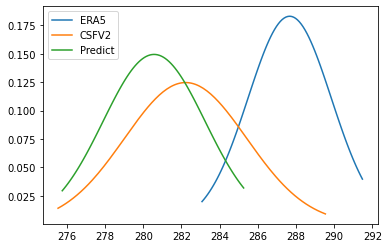

前90天
68 X_90 ERA5: 281.44 CSFV2: 294.25 Predict: 284.51
68 Y_90 ERA5: 2.72 CSFV2: 2.68 Predict: 4.18
68 Mean_90 ERA5: 287.54 CSFV2: 298.81 Predict: 292.77
68 STD_90 ERA5: 275.14 CSFV2: 287.42 Predict: 275.29
68 Maximum_90 ERA5: -0.05 CSFV2: -0.43 Predict: -0.14


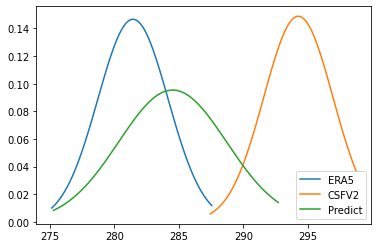

後90天
68 Minimum_90 ERA5: 285.44 CSFV2: 283.75 Predict: 279.85
68 Skewness_90 ERA5: 2.34 CSFV2: 3.97 Predict: 2.61
68 X_180 ERA5: 289.68 CSFV2: 291.64 Predict: 284.59
68 Y_180 ERA5: 280.83 CSFV2: 275.94 Predict: 275.11
68 Mean_180 ERA5: -0.17 CSFV2: 0.01 Predict: -0.13


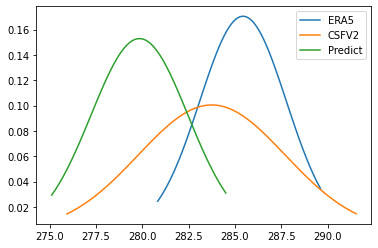

前90天
69 X_90 ERA5: 282.65 CSFV2: 294.39 Predict: 284.68
69 Y_90 ERA5: 3.18 CSFV2: 2.6 Predict: 4.27
69 Mean_90 ERA5: 289.72 CSFV2: 298.85 Predict: 293.01
69 STD_90 ERA5: 275.74 CSFV2: 287.68 Predict: 275.3
69 Maximum_90 ERA5: -0.08 CSFV2: -0.42 Predict: -0.14


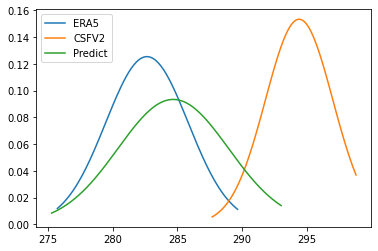

後90天
69 Minimum_90 ERA5: 288.62 CSFV2: 283.95 Predict: 279.75
69 Skewness_90 ERA5: 2.1 CSFV2: 4.03 Predict: 2.6
69 X_180 ERA5: 292.66 CSFV2: 291.79 Predict: 284.47
69 Y_180 ERA5: 284.54 CSFV2: 275.96 Predict: 275.02
69 Mean_180 ERA5: -0.09 CSFV2: -0.02 Predict: -0.12


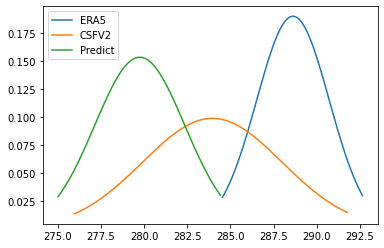

前90天
70 X_90 ERA5: 285.49 CSFV2: 295.02 Predict: 285.84
70 Y_90 ERA5: 4.43 CSFV2: 2.21 Predict: 4.35
70 Mean_90 ERA5: 293.93 CSFV2: 298.96 Predict: 294.05
70 STD_90 ERA5: 276.4 CSFV2: 289.25 Predict: 276.26
70 Maximum_90 ERA5: -0.13 CSFV2: -0.39 Predict: -0.18


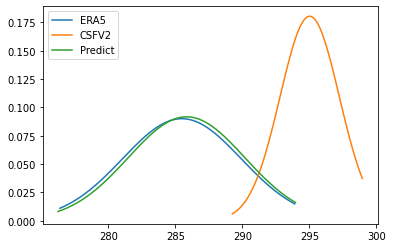

後90天
70 Minimum_90 ERA5: 280.9 CSFV2: 285.11 Predict: 279.9
70 Skewness_90 ERA5: 2.08 CSFV2: 4.38 Predict: 2.57
70 X_180 ERA5: 284.72 CSFV2: 293.19 Predict: 284.56
70 Y_180 ERA5: 276.69 CSFV2: 276.16 Predict: 275.18
70 Mean_180 ERA5: -0.16 CSFV2: -0.13 Predict: -0.12


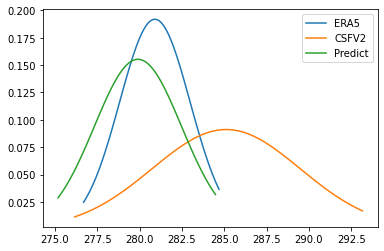

前90天
71 X_90 ERA5: 281.37 CSFV2: 290.52 Predict: 281.36
71 Y_90 ERA5: 2.64 CSFV2: 4.13 Predict: 2.89
71 Mean_90 ERA5: 287.4 CSFV2: 297.37 Predict: 288.31
71 STD_90 ERA5: 275.15 CSFV2: 280.43 Predict: 274.6
71 Maximum_90 ERA5: -0.04 CSFV2: -0.29 Predict: -0.02


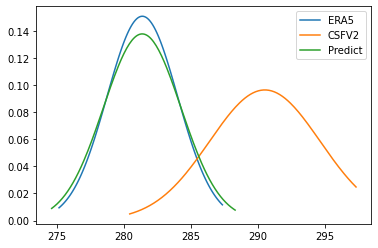

後90天
71 Minimum_90 ERA5: 284.85 CSFV2: 281.37 Predict: 283.39
71 Skewness_90 ERA5: 2.29 CSFV2: 2.66 Predict: 2.71
71 X_180 ERA5: 289.22 CSFV2: 287.78 Predict: 288.06
71 Y_180 ERA5: 280.45 CSFV2: 275.14 Predict: 278.51
71 Mean_180 ERA5: -0.1 CSFV2: -0.01 Predict: -0.21


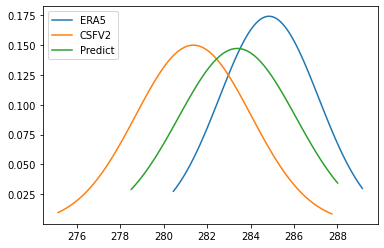

前90天
72 X_90 ERA5: 282.49 CSFV2: 291.42 Predict: 281.63
72 Y_90 ERA5: 3.37 CSFV2: 3.72 Predict: 3.09
72 Mean_90 ERA5: 290.26 CSFV2: 297.54 Predict: 288.84
72 STD_90 ERA5: 275.64 CSFV2: 282.09 Predict: 274.49
72 Maximum_90 ERA5: 0.16 CSFV2: -0.28 Predict: -0.03


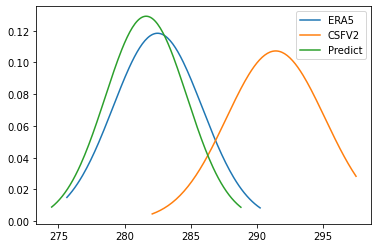

後90天
72 Minimum_90 ERA5: 281.83 CSFV2: 281.49 Predict: 282.28
72 Skewness_90 ERA5: 2.62 CSFV2: 2.79 Predict: 2.71
72 X_180 ERA5: 286.54 CSFV2: 288.13 Predict: 287.0
72 Y_180 ERA5: 276.54 CSFV2: 275.14 Predict: 277.42
72 Mean_180 ERA5: -0.21 CSFV2: 0.04 Predict: -0.19


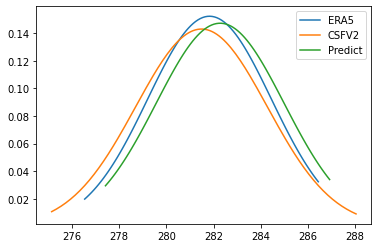

前90天
73 X_90 ERA5: 281.63 CSFV2: 285.49 Predict: 282.35
73 Y_90 ERA5: 2.86 CSFV2: 4.43 Predict: 3.27
73 Mean_90 ERA5: 288.28 CSFV2: 293.93 Predict: 289.49
73 STD_90 ERA5: 275.25 CSFV2: 276.4 Predict: 274.89
73 Maximum_90 ERA5: 0.08 CSFV2: -0.13 Predict: -0.08


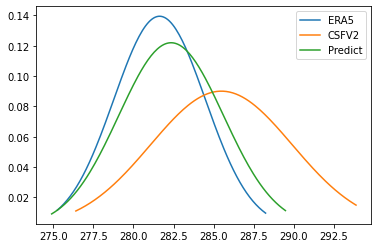

後90天
73 Minimum_90 ERA5: 283.11 CSFV2: 282.65 Predict: 288.31
73 Skewness_90 ERA5: 2.16 CSFV2: 3.18 Predict: 2.43
73 X_180 ERA5: 286.94 CSFV2: 289.72 Predict: 292.5
73 Y_180 ERA5: 278.37 CSFV2: 275.74 Predict: 283.67
73 Mean_180 ERA5: -0.37 CSFV2: -0.08 Predict: -0.24


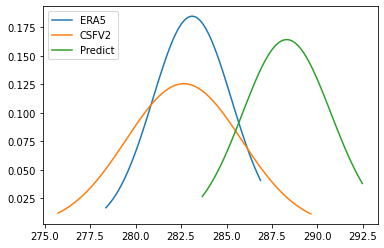

前90天
74 X_90 ERA5: 281.96 CSFV2: 288.15 Predict: 281.28
74 Y_90 ERA5: 3.06 CSFV2: 4.55 Predict: 2.83
74 Mean_90 ERA5: 289.14 CSFV2: 296.16 Predict: 288.09
74 STD_90 ERA5: 275.48 CSFV2: 278.17 Predict: 274.65
74 Maximum_90 ERA5: 0.13 CSFV2: -0.31 Predict: -0.02


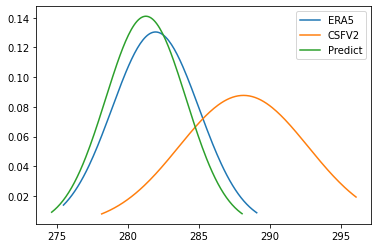

後90天
74 Minimum_90 ERA5: 282.55 CSFV2: 281.59 Predict: 285.47
74 Skewness_90 ERA5: 2.37 CSFV2: 2.78 Predict: 2.65
74 X_180 ERA5: 286.61 CSFV2: 287.68 Predict: 290.01
74 Y_180 ERA5: 277.37 CSFV2: 275.2 Predict: 280.62
74 Mean_180 ERA5: -0.38 CSFV2: -0.08 Predict: -0.24


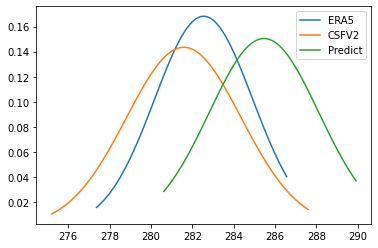

前90天
75 X_90 ERA5: 282.57 CSFV2: 294.17 Predict: 284.42
75 Y_90 ERA5: 3.19 CSFV2: 2.71 Predict: 4.16
75 Mean_90 ERA5: 289.69 CSFV2: 298.78 Predict: 292.66
75 STD_90 ERA5: 275.57 CSFV2: 287.34 Predict: 275.24
75 Maximum_90 ERA5: -0.07 CSFV2: -0.43 Predict: -0.13


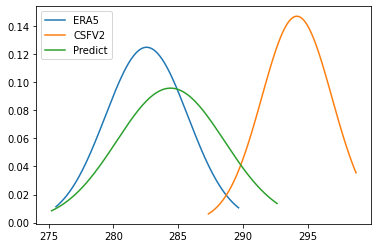

後90天
75 Minimum_90 ERA5: 288.48 CSFV2: 283.65 Predict: 279.86
75 Skewness_90 ERA5: 2.1 CSFV2: 3.93 Predict: 2.61
75 X_180 ERA5: 292.52 CSFV2: 291.54 Predict: 284.6
75 Y_180 ERA5: 284.42 CSFV2: 275.93 Predict: 275.12
75 Mean_180 ERA5: -0.09 CSFV2: 0.02 Predict: -0.13


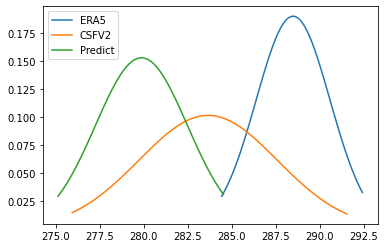

前90天
76 X_90 ERA5: 285.22 CSFV2: 291.79 Predict: 281.98
76 Y_90 ERA5: 4.4 CSFV2: 3.52 Predict: 3.24
76 Mean_90 ERA5: 293.34 CSFV2: 297.65 Predict: 289.34
76 STD_90 ERA5: 276.18 CSFV2: 283.3 Predict: 274.55
76 Maximum_90 ERA5: -0.14 CSFV2: -0.26 Predict: -0.04


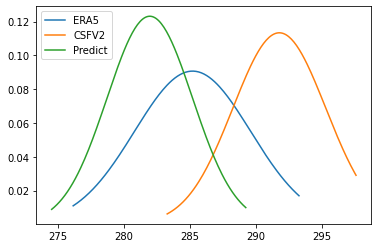

後90天
76 Minimum_90 ERA5: 280.95 CSFV2: 281.55 Predict: 281.62
76 Skewness_90 ERA5: 2.03 CSFV2: 2.82 Predict: 2.7
76 X_180 ERA5: 284.73 CSFV2: 288.19 Predict: 286.36
76 Y_180 ERA5: 276.94 CSFV2: 275.21 Predict: 276.77
76 Mean_180 ERA5: -0.17 CSFV2: 0.06 Predict: -0.18


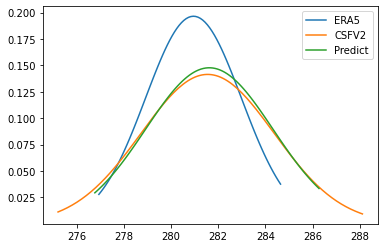

前90天
77 X_90 ERA5: 284.79 CSFV2: 295.11 Predict: 286.26
77 Y_90 ERA5: 4.28 CSFV2: 2.14 Predict: 4.32
77 Mean_90 ERA5: 292.96 CSFV2: 298.98 Predict: 294.37
77 STD_90 ERA5: 276.12 CSFV2: 289.72 Predict: 276.72
77 Maximum_90 ERA5: -0.1 CSFV2: -0.37 Predict: -0.19


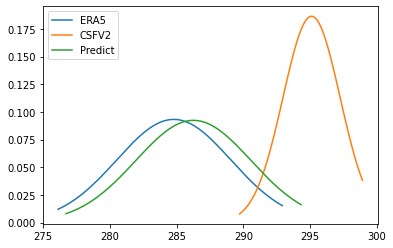

後90天
77 Minimum_90 ERA5: 280.73 CSFV2: 285.35 Predict: 280.11
77 Skewness_90 ERA5: 2.1 CSFV2: 4.41 Predict: 2.57
77 X_180 ERA5: 284.67 CSFV2: 293.59 Predict: 284.75
77 Y_180 ERA5: 276.61 CSFV2: 276.26 Predict: 275.38
77 Mean_180 ERA5: -0.16 CSFV2: -0.14 Predict: -0.13


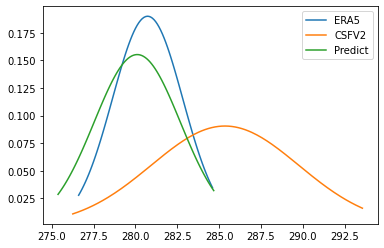

前90天
78 X_90 ERA5: 281.87 CSFV2: 286.07 Predict: 281.9
78 Y_90 ERA5: 2.96 CSFV2: 4.46 Predict: 3.09
78 Mean_90 ERA5: 288.62 CSFV2: 294.67 Predict: 288.9
78 STD_90 ERA5: 275.24 CSFV2: 277.19 Predict: 274.76
78 Maximum_90 ERA5: -0.06 CSFV2: -0.12 Predict: -0.05


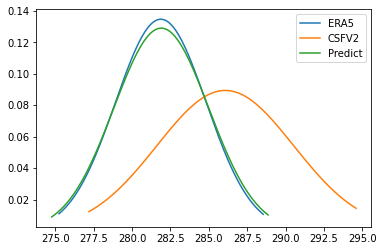

後90天
78 Minimum_90 ERA5: 287.58 CSFV2: 282.35 Predict: 286.92
78 Skewness_90 ERA5: 2.16 CSFV2: 3.18 Predict: 2.53
78 X_180 ERA5: 291.42 CSFV2: 289.43 Predict: 291.28
78 Y_180 ERA5: 283.04 CSFV2: 275.29 Predict: 282.16
78 Mean_180 ERA5: -0.21 CSFV2: -0.08 Predict: -0.24


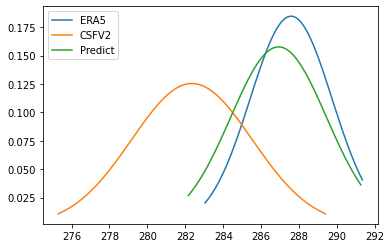

前90天
79 X_90 ERA5: 281.42 CSFV2: 293.37 Predict: 283.48
79

KeyboardInterrupt: 

In [36]:
#平均作圖PDF
Pic=0
for data in y_predict:
    
    #前90天
    print('前90天')
    PDF_average(data, 0, 5, Pic)
    
    #後90天
    print('後90天')
    PDF_average(data, 5, 10, Pic)
    
    Pic=Pic+1